In [1]:
# %pip install CoolProp
# %pip install seaborn
# %pip install openpyxl


In [2]:
import CoolProp.CoolProp as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pickle
import contextlib
from tqdm import tqdm  # Import tqdm for progress bar


import DiadFit as pf
pf.__version__


'1.0.5'

In [3]:
# Setting plotting parameters
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["font.size"] =12
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1 
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.major.size"] = 6 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 6 # Sets length of ticks
plt.rcParams["xtick.minor.size"] = 3 # Sets length of ticks
plt.rcParams["ytick.minor.size"] = 3 # Sets length of ticks
plt.rcParams["ytick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["xtick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["axes.titlesize"] = 14 # Overall title
plt.rcParams["axes.labelsize"] = 14 # Axes labels
plt.rcParams["pdf.fonttype"]=42
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["legend.fancybox"]=False

In [4]:
if os.name=='posix':
    slash='/'
else:
    slash='\\'

MasterFolder=os.getcwd()

# rep_FI_path=os.path.join(Helperfile_folder, "Leilani_repeated_names.xlsx") #r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Helper_files\Leilaini_repeated_names.xlsx"

#Folder to save figures

figpath=MasterFolder +slash+'Figs'
if not os.path.exists(figpath):
    os.mkdir(figpath)

#Folder to save full datasets

compilation_folder=MasterFolder +slash+'Compiled_data'
if not os.path.exists(compilation_folder):
    os.mkdir(compilation_folder)

In [5]:

## This function compiles raman sessions found in the master folder (even in subdirectories of the specified folder)

def compile_Raman_sessions(*, path=None, sheet_name='Sheet1', keyword='Raman_session'):
    df = pd.DataFrame()

    for root, dirs, files in os.walk(path):
        for file in files:
            if keyword in file and file.endswith('.xlsx'):
                file_path = os.path.join(root, file)
                sheets = pd.read_excel(file_path, sheet_name)
                df = pd.concat([df, sheets], axis=0, ignore_index=True)
                unnamed_columns = [col for col in df.columns if 'Unnamed' in col]
                df = df.drop(columns=unnamed_columns)

    return df

In [6]:
# relative_path = os.path.join("..", "..","Melt inclusions", "Compiled_data", "KAM_averaged.xlsx")
# file_path = os.path.normpath(os.path.join(os.getcwd(), relative_path))

# kamaehu_MIruns = pd.read_excel(file_path)
# kamaehu_MIruns = kamaehu_MIruns.loc[:, ~kamaehu_MIruns.columns.str.contains('^Unnamed')]

# kamaehu_MIruns.to_clipboard(excel=True,index=False)

In [7]:
kamaehu = compile_Raman_sessions(path=os.path.join(MasterFolder,"Sessionfiles"),sheet_name='Sheet1',keyword='Raman')

kamaehu = kamaehu[(~kamaehu['filename'].str.contains('test'))&(kamaehu['Density g/cm3']>0)&~(kamaehu['σ Density g/cm3']>0.04)]

kamaehu['date_object']=pd.to_datetime(kamaehu['date'])

kamaehu=kamaehu.sort_values(by=['date_object', 'filename'])

kamaehu.to_clipboard(excel=True, index=False)

kamaehu.to_excel(compilation_folder+'/'+"KAM.xlsx")

kamaehu

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,lower_values,upper_values,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name_x,Model_name_y,SO2_Diad_Ratio,SO2_mol_ratio,date_object
286,L87-1-101-reg1-FIA-r1,0.312759,0.003972,0.003201,0.002351,103.513380,0.007506,0.000394,0.007512,6.006,...,0.997751,0.997758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-04
287,L87-1-101-reg1-FIA-r2,0.310070,0.003187,0.002151,0.002351,103.507071,0.005049,0.000394,0.005045,6.006,...,0.997749,0.997757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-04
288,L87-1-101-reg1-FIA-r3,0.306799,0.003183,0.002145,0.002351,103.499388,0.005042,0.000394,0.005038,6.007,...,0.997748,0.997755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-04
289,L87-1-101-reg1-FIB-r1,0.230628,0.004543,0.003881,0.002361,103.317722,0.009386,0.000394,0.009399,6.001,...,0.997746,0.997754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-04
290,L87-1-101-reg1-FIB-r2,0.230371,0.004612,0.003962,0.002361,103.317102,0.009581,0.000395,0.009595,6.000,...,0.997745,0.997752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,KA961_c156_a1_FIA,0.217436,0.004140,0.003400,0.002363,103.285747,0.008259,0.000543,0.008259,9.969,...,0.997773,0.997784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-03
821,KA961_c157_a1_FIA,0.144865,0.006328,0.004995,0.003884,103.115854,0.012606,0.000545,0.012622,9.994,...,0.997772,0.997783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-03
822,KA961_c158_a1_FIA,0.182039,0.002753,0.001400,0.002371,103.199255,0.003441,0.000549,0.003405,9.992,...,0.997771,0.997781,1150.724292,223.637646,147.176929,Spline,NaN,0.052269,0.022085,2024-12-03
823,KA961_c158_a2_FIB,0.092390,0.004631,0.002645,0.003802,102.983422,0.006674,0.000550,0.006666,9.978,...,0.997770,0.997781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-03


# Now merge in the helper frame with the new naming convention and clean name tags

In [8]:
rep_FI_names=pd.read_excel('Helper_file_120624.xlsx',sheet_name='helper_MIFI_diads')
kamaehu_reps = pd.merge(rep_FI_names, kamaehu, on=['filename', 'date_object'])
kamaehu_reps

,filename,date_object,Type,Mount,Sample,Crystal,Region,FI#,Sample_crystal,Sample_crystal_region,...,preferred_values,lower_values,upper_values,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name_x,Model_name_y,SO2_Diad_Ratio,SO2_mol_ratio
0,L87-1-101-reg1-FIA-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIA,KA71_c101,KA71_c101_a1,...,0.997754,0.997751,0.997758,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,L87-1-101-reg1-FIA-r2,2024-01-04,Sample,R3,KA71,c101,a1,FIA,KA71_c101,KA71_c101_a1,...,0.997753,0.997749,0.997757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,L87-1-101-reg1-FIA-r3,2024-01-04,Sample,R3,KA71,c101,a1,FIA,KA71_c101,KA71_c101_a1,...,0.997751,0.997748,0.997755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,L87-1-101-reg1-FIB-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIB,KA71_c101,KA71_c101_a1,...,0.997750,0.997746,0.997754,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,L87-1-101-reg1-FIB-r2,2024-01-04,Sample,R3,KA71,c101,a1,FIB,KA71_c101,KA71_c101_a1,...,0.997749,0.997745,0.997752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,KA961_c156_a1_FIA,2024-12-03,Sample,KAM6,KA961,c156,a1,FIA,KA961_c156,KA961_c156_a1,...,0.997778,0.997773,0.997784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1070,KA961_c157_a1_FIA,2024-12-03,Sample,KAM6,KA961,c157,a1,FIA,KA961_c157,KA961_c157_a1,...,0.997777,0.997772,0.997783,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1071,KA961_c158_a1_FIA,2024-12-03,Sample,KAM6,KA961,c158,a1,FIA,KA961_c158,KA961_c158_a1,...,0.997776,0.997771,0.997781,1150.724292,223.637646,147.176929,Spline,NaN,0.052269,0.022085
1072,KA961_c158_a2_FIB,2024-12-03,Sample,KAM6,KA961,c158,a2,FIB,KA961_c158,KA961_c158_a2,...,0.997775,0.997770,0.997781,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Means of reps of my data

In [9]:
grouped = kamaehu_reps.groupby('Name_full')

# Separate numeric and non-numeric columns
numeric_cols = kamaehu_reps.select_dtypes(include='number')
non_numeric_cols = kamaehu_reps.select_dtypes(exclude='number')

# Aggregate numeric columns by mean and standard deviation
numeric_kamaehu_averaged_mean = grouped[numeric_cols.columns].mean()
numeric_kamaehu_averaged_std = grouped[numeric_cols.columns].std()

# Take the first instance for non-numeric columns
non_numeric_kamaehu_averaged = grouped[non_numeric_cols.columns].first()

# Concatenate kamaehu_averageds and reindex columns to the original order
kamaehu_averaged = pd.concat([numeric_kamaehu_averaged_mean, non_numeric_kamaehu_averaged], axis=1)
kamaehu_averaged = kamaehu_averaged.reindex(columns=kamaehu_reps.columns)

# Add standard deviation columns after reindexing
kamaehu_averaged = pd.concat([kamaehu_averaged, numeric_kamaehu_averaged_std.add_suffix('_Raman_STD')], axis=1)

# Reset index to get a DataFrame
kamaehu_averaged = kamaehu_averaged.reset_index(drop=True)

row_counts = grouped.size().reset_index(name='row_count')

# Add a new column "averaged?" based on the row count
row_counts['averaged?'] = 'No'
row_counts.loc[row_counts['row_count'] > 1, 'averaged?'] = 'Yes'

# Merge the row counts back to the aggregated DataFrame
kamaehu_averaged = pd.merge(kamaehu_averaged, row_counts[['Name_full', 'averaged?']], on='Name_full', how='left')

# If there are missing values (groups with a single row), fill them with 'No'
kamaehu_averaged['averaged?'] = kamaehu_averaged['averaged?'].fillna('No')

#exclude a weird null average spectrum
kamaehu_averaged=kamaehu_averaged[~(kamaehu_averaged['filename'].str.contains("186-9-118-A"))]
kamaehu_averaged.to_excel(compilation_folder+'/'+"KAM_averaged.xlsx")

kamaehu_averaged


,filename,date_object,Type,Mount,Sample,Crystal,Region,FI#,Sample_crystal,Sample_crystal_region,...,time_Raman_STD,preferred_values_Raman_STD,lower_values_Raman_STD,upper_values_Raman_STD,Peak_Cent_SO2_Raman_STD,Peak_Area_SO2_Raman_STD,Peak_Height_SO2_Raman_STD,SO2_Diad_Ratio_Raman_STD,SO2_mol_ratio_Raman_STD,averaged?
0,FG04-A1-1--Spectrum--151,2024-05-28,Std,None,FG04,A1,None,1,FG04_A1,FG04_A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1,FG04-A1-1-end--Spectrum--186,2024-05-29,Std,None,FG04,A1,None,1,FG04_A1,FG04_A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,FG04-A1-1-end--Spectrum--124,2024-06-03,Std,None,FG04,A1,None,1,FG04_A1,FG04_A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3,FG04-A1-4-end-rep4,2024-11-25,Std,None,FG04,A1,None,1,FG04_A1,FG04_A1,...,389.851681,0.000001,0.000001,0.000001,NaN,NaN,NaN,NaN,NaN,Yes
4,FG04-A1-4_end_rep4,2024-11-26,Std,None,FG04,A1,None,1,FG04_A1,FG04_A1,...,331.998494,0.000002,0.000002,0.000002,NaN,NaN,NaN,NaN,NaN,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,KA961_c156_a1_FIA,2024-12-03,Sample,KAM6,KA961,c156,a1,FIA,KA961_c156,KA961_c156_a1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
668,KA961_c157_a1_FIA,2024-12-03,Sample,KAM6,KA961,c157,a1,FIA,KA961_c157,KA961_c157_a1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
669,KA961_c158_a1_FIA,2024-12-03,Sample,KAM6,KA961,c158,a1,FIA,KA961_c158,KA961_c158_a1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
670,KA961_c158_a2_FIB,2024-12-03,Sample,KAM6,KA961,c158,a2,FIB,KA961_c158,KA961_c158_a2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


## Let's add the MI with no diads

In [10]:
MI_nodiads=pd.read_excel(r"Helper_file_120624.xlsx",sheet_name="helper_MI_nodiads")

kamaehu_averaged_final=pd.concat([kamaehu_averaged,MI_nodiads],axis=0,ignore_index=True)
kamaehu_averaged_final=kamaehu_averaged_final.sort_values(by='date_object')
kamaehu_averaged_final.to_excel(compilation_folder+'/'+"KAM_averaged_ALL.xlsx")

kamaehu_averaged_final['Bubble type (MI)'] = kamaehu_averaged_final['Bubble type (MI)'].fillna('measured')

kamaehu_averaged_final.to_clipboard(excel=True,index=False)
kamaehu_averaged_final

,filename,date_object,Type,Mount,Sample,Crystal,Region,FI#,Sample_crystal,Sample_crystal_region,...,preferred_values_Raman_STD,lower_values_Raman_STD,upper_values_Raman_STD,Peak_Cent_SO2_Raman_STD,Peak_Area_SO2_Raman_STD,Peak_Height_SO2_Raman_STD,SO2_Diad_Ratio_Raman_STD,SO2_mol_ratio_Raman_STD,averaged?,Bubble type (MI)
229,L87-1-101-reg1-FIA-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIA,KA71_c101,KA71_c101_a1,...,0.000002,0.000002,0.000002,NaN,NaN,NaN,NaN,NaN,Yes,measured
231,L87-1-101-reg1-FIC-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIC,KA71_c101,KA71_c101_a1,...,0.000001,0.000001,0.000001,NaN,NaN,NaN,NaN,NaN,Yes,measured
232,L87-1-101-reg2-FIA-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIA,KA71_c101,KA71_c101_a2,...,0.000003,0.000003,0.000003,NaN,NaN,NaN,NaN,NaN,Yes,measured
233,L87-1-101-reg2-FIB-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIB,KA71_c101,KA71_c101_a2,...,0.000002,0.000002,0.000002,NaN,NaN,NaN,NaN,NaN,Yes,measured
234,L87-1-101-reg2-FIC-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIC,KA71_c101,KA71_c101_a2,...,0.000001,0.000001,0.000001,NaN,NaN,NaN,NaN,NaN,Yes,measured
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,187-9-203b-MIB-nodiad,NaT,Sample,NaN,KA79,c203b,NaN,MIB,KA79_c203b,KA79_c203b_MIB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nd
712,187-9-223-MIA-unquantdiad,NaT,Sample,NaN,KA79,c223,NaN,MIA,KA79_c223,KA79_c223_MIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bd
713,187-9-219-MIA-rep1-nodiad,NaT,Sample,NaN,KA79,c219,NaN,MIA,KA79_c219,KA79_c219_MIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nd
714,186-11-214-MIA-nodiad,NaT,Sample,NaN,KA611,c214,NaN,MIA,KA611_c214,KA611_c214_MIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nd


# This is temporary just to copy the correct EDS names

In [11]:
# EDS_oldnames=pd.read_excel("Helper_file_120524.xlsx",sheet_name="EDS_merge")
# test=pd.merge(right=EDS_oldnames,left=kamaehu_averaged_final,on='filename',how='outer')
# test=test.sort_values(by="date_object")
# test.iloc[:,:12].to_clipboard(excel=True,index=False)
# test[['filename','date_object','Name_full','EDS_name','EDS_MIglass_name','EDS_matrixglass_name','Status comment']].to_clipboard(excel=True,index=False)


# Now merge the EDS mineral data in

In [12]:
eds_merge_names=pd.read_excel(r"Helper_file_120624.xlsx",sheet_name="EDS_merge")
kam_w_EDSnames=pd.merge(left=kamaehu_averaged_final,on=['filename','date_object'],right=eds_merge_names,how='left')

EDS_data=pd.read_excel(r"KAM_EDS_12062024.xlsx",sheet_name="concatenated_olivines")

EDS_data = EDS_data.loc[:, ~EDS_data.columns.str.contains('^Unnamed')]

EDS_data.columns = [col + '_host' for col in EDS_data.columns] 

kam_w_EDS=pd.merge(left=kam_w_EDSnames,left_on='EDS_name',right=EDS_data,right_on='Sample Name_host',how='left',suffixes=(None,"_host"))

kam_w_EDS = kam_w_EDS.dropna(subset=['filename'])
kam_w_EDS = kam_w_EDS[~kam_w_EDS['filename'].str.contains("187-1-115-C")]
kam_w_EDS=kam_w_EDS.sort_values(by='date_object')
kam_w_EDS=kam_w_EDS.dropna(axis=1, how='all')
kam_w_EDS.to_excel(compilation_folder+'/'+"KAM_all_wEDS_hosts.xlsx")

kam_w_EDS

,filename,date_object,Type,Mount,Sample,Crystal,Region,FI#,Sample_crystal,Sample_crystal_region,...,#_ions__O_host,#_ions__Mg_host,#_ions__Si_host,#_ions__Ca_host,#_ions__Cr_host,#_ions__Mn_host,#_ions__Fe_host,#_ions__Ni_host,Fo_host,K2O_host
0,L87-1-101-reg1-FIA-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIA,KA71_c101,KA71_c101_a1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.864657,0.0
1,L87-1-101-reg1-FIC-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIC,KA71_c101,KA71_c101_a1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.864657,0.0
2,L87-1-101-reg2-FIA-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIA,KA71_c101,KA71_c101_a2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866154,0.0
3,L87-1-101-reg2-FIB-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIB,KA71_c101,KA71_c101_a2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866154,0.0
4,L87-1-101-reg2-FIC-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIC,KA71_c101,KA71_c101_a2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866154,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,187-9-203b-MIB-nodiad,NaT,Sample,NaN,KA79,c203b,NaN,MIB,KA79_c203b,KA79_c203b_MIB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
713,187-9-223-MIA-unquantdiad,NaT,Sample,NaN,KA79,c223,NaN,MIA,KA79_c223,KA79_c223_MIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
714,187-9-219-MIA-rep1-nodiad,NaT,Sample,NaN,KA79,c219,NaN,MIA,KA79_c219,KA79_c219_MIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
715,186-11-214-MIA-nodiad,NaT,Sample,NaN,KA611,c214,NaN,MIA,KA611_c214,KA611_c214_MIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


# Calculate SO2 mol fraction

In [13]:
kam_w_EDS['SO2 mol%']=pf.calculate_mole_fraction_2comp(peak_area_a=kam_w_EDS['Peak_Area_SO2'], peak_area_b=kam_w_EDS['Diad1_Voigt_Area']+kam_w_EDS['Diad2_Voigt_Area'],
                                  cross_section_a=5.3, cross_section_b=1.4+0.89, instrument_eff_a=1, instrument_eff_b=1)['% A']


kam_w_EDS['Fo_host']=(kam_w_EDS['MgO_host']/40.3044)/((kam_w_EDS['MgO_host']/40.3044)+(kam_w_EDS['FeOt_host']/71.844))




## Now let's calculate a first temperature from Fo content.

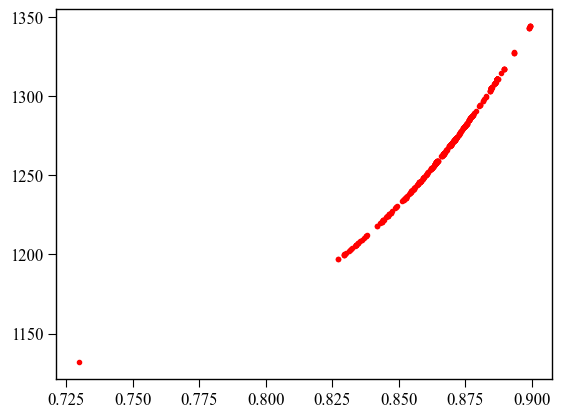

In [14]:
## For now, use the model for Kilauea, I will calculate a new one for Kam later. Need to compile data to do it

with open('TempFoModel.pkl', 'rb') as f:
    Pf_TempFo = pickle.load(f)


kam_w_EDS['Temp_from_Fo_all']=Pf_TempFo(kam_w_EDS['Fo_host'])
MeanT=np.nanmean(kam_w_EDS['Temp_from_Fo_all'])
kam_w_EDS['Temp_from_Fo_all'] = kam_w_EDS['Temp_from_Fo_all'].fillna(MeanT)

# Create 'Temp_error' column based on whether 'Temp_from_Fo' is a number
kam_w_EDS['Temp_error'] = np.where(kam_w_EDS['Temp_from_Fo_all'] == MeanT, 100, 50)



plt.plot(kam_w_EDS['Fo_host'], kam_w_EDS['Temp_from_Fo_all'], '.r')

## Add the matrix glass data 

In [15]:
EDS_matglass=pd.read_excel(compilation_folder+'/'+"KAM_matgl_averaged_averaged_sample.xlsx",sheet_name="Sheet1")

EDS_matglass = EDS_matglass.loc[:, ~EDS_matglass.columns.str.contains('^Unnamed')]

EDS_matglass.columns = [col + '_matgl' for col in EDS_matglass.columns] 

kam_w_EDS_matgl=pd.merge(left=kam_w_EDS,left_on='Sample',right=EDS_matglass,right_on='Sample_matgl',how='left',suffixes=(None,"_matgl"))


kam_w_EDS_matgl=kam_w_EDS_matgl.sort_values(by='date_object')
kam_w_EDS_matgl=kam_w_EDS_matgl.dropna(axis=1, how='all')

kam_w_EDS_matgl.to_excel(compilation_folder+'/'+"KAM_all_wEDS_hosts+matgl.xlsx")
kam_w_EDS_matgl

,filename,date_object,Type,Mount,Sample,Crystal,Region,FI#,Sample_crystal,Sample_crystal_region,...,"Cr2O3_wt%uncertainty (Cr2O3_sample_std when it was averaged, Cr2O3_Oxide sigma% when it was a single spot)_matgl","FeOt_wt%uncertainty (FeOt_sample_std when it was averaged, FeOt_Oxide sigma% when it was a single spot)_matgl","K2O_wt%uncertainty (K2O_sample_std when it was averaged, K2O_Oxide sigma% when it was a single spot)_matgl","MgO_wt%uncertainty (MgO_sample_std when it was averaged, MgO_Oxide sigma% when it was a single spot)_matgl","MnO_wt%uncertainty (MnO_sample_std when it was averaged, MnO_Oxide sigma% when it was a single spot)_matgl","Na2O_wt%uncertainty (Na2O_sample_std when it was averaged, Na2O_Oxide sigma% when it was a single spot)_matgl","P2O5_wt%uncertainty (P2O5_sample_std when it was averaged, P2O5_Oxide sigma% when it was a single spot)_matgl","SO3_wt%uncertainty (SO3_sample_std when it was averaged, SO3_Oxide sigma% when it was a single spot)_matgl","SiO2_wt%uncertainty (SiO2_sample_std when it was averaged, SiO2_Oxide sigma% when it was a single spot)_matgl","TiO2_wt%uncertainty (TiO2_sample_std when it was averaged, TiO2_Oxide sigma% when it was a single spot)_matgl"
0,L87-1-101-reg1-FIA-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIA,KA71_c101,KA71_c101_a1,...,0.014994,0.041386,0.007849,0.089156,0.01215,0.033502,0.01588,0.014329,0.256646,0.019322
1,L87-1-101-reg1-FIC-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIC,KA71_c101,KA71_c101_a1,...,0.014994,0.041386,0.007849,0.089156,0.01215,0.033502,0.01588,0.014329,0.256646,0.019322
2,L87-1-101-reg2-FIA-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIA,KA71_c101,KA71_c101_a2,...,0.014994,0.041386,0.007849,0.089156,0.01215,0.033502,0.01588,0.014329,0.256646,0.019322
3,L87-1-101-reg2-FIB-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIB,KA71_c101,KA71_c101_a2,...,0.014994,0.041386,0.007849,0.089156,0.01215,0.033502,0.01588,0.014329,0.256646,0.019322
4,L87-1-101-reg2-FIC-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIC,KA71_c101,KA71_c101_a2,...,0.014994,0.041386,0.007849,0.089156,0.01215,0.033502,0.01588,0.014329,0.256646,0.019322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,187-9-203b-MIB-nodiad,NaT,Sample,NaN,KA79,c203b,NaN,MIB,KA79_c203b,KA79_c203b_MIB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712,187-9-223-MIA-unquantdiad,NaT,Sample,NaN,KA79,c223,NaN,MIA,KA79_c223,KA79_c223_MIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
713,187-9-219-MIA-rep1-nodiad,NaT,Sample,NaN,KA79,c219,NaN,MIA,KA79_c219,KA79_c219_MIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
714,186-11-214-MIA-nodiad,NaT,Sample,NaN,KA611,c214,NaN,MIA,KA611_c214,KA611_c214_MIA,...,0.021700,0.056000,0.014900,0.039200,0.02280,0.033300,0.02650,0.024200,0.090000,0.030600


## And add Mike Garcia's glass data

In [16]:
Garcia_glasses=pd.read_excel(r"1995MOG_EastFlank.xlsx",sheet_name="Garcia_glasses")

Garcia_glasses.rename(columns={'Sample': 'Sample_old', 'Type': 'Rock type'}, inplace=True)

def create_new_sample(sample_str):
    parts = sample_str.split('-')
    new_sample = f"KA{parts[0][-1]}{parts[1]}"
    return new_sample

Garcia_glasses['Sample'] = Garcia_glasses['Sample_old'].apply(create_new_sample)
Garcia_glasses.insert(0,'Sample',Garcia_glasses.pop("Sample"))

Garcia_glasses.columns = [col + '_garciagl' for col in Garcia_glasses.columns] 


kam_w_EDS_allgl=pd.merge(left=kam_w_EDS_matgl,left_on='Sample',right=Garcia_glasses,right_on='Sample_garciagl',how='left',suffixes=(None,"_garciagl"))


kam_w_EDS_allgl=kam_w_EDS_allgl.sort_values(by='date_object')
kam_w_EDS_allgl=kam_w_EDS_allgl.dropna(axis=1, how='all')

kam_w_EDS_allgl.to_excel(compilation_folder+'/'+"KAM_all_wEDS_hosts+matgl+garciagl.xlsx")
kam_w_EDS_allgl

,filename,date_object,Type,Mount,Sample,Crystal,Region,FI#,Sample_crystal,Sample_crystal_region,...,Matrix_garciagl,Ol_garciagl,Ol mu_garciagl,Opaq_garciagl,Plag_garciagl,Plag mu_garciagl,Cpx_garciagl,Cpxji_garciagl,Ves_garciagl,SUMphens_garciagl
0,L87-1-101-reg1-FIA-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIA,KA71_c101,KA71_c101_a1,...,72.5,22.2,5,0.3,—,—,—,—,12.9,22.2
1,L87-1-101-reg1-FIC-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIC,KA71_c101,KA71_c101_a1,...,72.5,22.2,5,0.3,—,—,—,—,12.9,22.2
2,L87-1-101-reg2-FIA-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIA,KA71_c101,KA71_c101_a2,...,72.5,22.2,5,0.3,—,—,—,—,12.9,22.2
3,L87-1-101-reg2-FIB-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIB,KA71_c101,KA71_c101_a2,...,72.5,22.2,5,0.3,—,—,—,—,12.9,22.2
4,L87-1-101-reg2-FIC-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIC,KA71_c101,KA71_c101_a2,...,72.5,22.2,5,0.3,—,—,—,—,12.9,22.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,187-9-203b-MIB-nodiad,NaT,Sample,NaN,KA79,c203b,NaN,MIB,KA79_c203b,KA79_c203b_MIB,...,91.6,4.1,4.3,—,—,—,—,0.3,4.2,4.1
712,187-9-223-MIA-unquantdiad,NaT,Sample,NaN,KA79,c223,NaN,MIA,KA79_c223,KA79_c223_MIA,...,91.6,4.1,4.3,—,—,—,—,0.3,4.2,4.1
713,187-9-219-MIA-rep1-nodiad,NaT,Sample,NaN,KA79,c219,NaN,MIA,KA79_c219,KA79_c219_MIA,...,91.6,4.1,4.3,—,—,—,—,0.3,4.2,4.1
714,186-11-214-MIA-nodiad,NaT,Sample,NaN,KA611,c214,NaN,MIA,KA611_c214,KA611_c214_MIA,...,75.5,23.1,0.8,0.1,—,—,<0.1,0.5,13.9,23.1


## Now separate the FI from the MI for the rest.

In [17]:

## Here we'll separate the MI from the FI
kam_w_EDS_allgl.to_excel(compilation_folder+'/'+"KAM_all_wEDS_hosts+matgl.xlsx")
MI_wEDS=kam_w_EDS_allgl[kam_w_EDS_allgl["filename"].str.contains("MI")]
MI_wEDS.to_excel(compilation_folder+'/'+"KAM_MI_wEDS_hosts+matgl.xlsx")
FI_wEDS=kam_w_EDS_allgl[~kam_w_EDS_allgl["filename"].str.contains("MI")]
FI_wEDS.to_excel(compilation_folder+'/'+"KAM_FI_wEDS_hosts+matgl.xlsx")

## Now we can look at the FI - we'll look at MI later 

# Now calculate pure CO2 pressure as starting point

In [18]:
P_SW96=pf.calculate_P_for_rho_T(CO2_dens_gcm3=FI_wEDS['Density g/cm3'], 
                                T_K=FI_wEDS['Temp_from_Fo_all']+273.15, EOS='SW96')
P_SW96.head()

,P_kbar,P_MPa,T_K,CO2_dens_gcm3
0,1.150068,115.006845,1532.376140,0.309876
1,0.868397,86.839721,1532.376140,0.247981
2,1.249708,124.970844,1535.467028,0.329489
3,1.527175,152.717463,1535.467028,0.381455
4,1.321161,132.116050,1535.467028,0.343428


## Now let's calculate XH2O from the Schipper polynomial

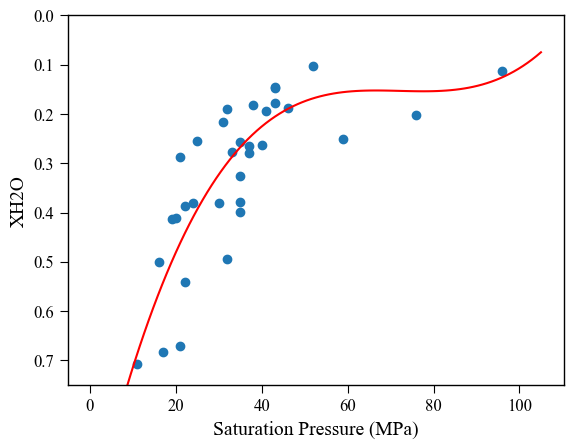

In [19]:
schipperMI=pd.read_excel(r"kamaehu_MI_Schipper11.xlsx")
schipperMI.head()

P_MI_MPa=schipperMI["SaturationP_bars_VESIcal"]/10
plt.scatter(P_MI_MPa,schipperMI["XH2O_fl_VESIcal"])
plt.ylim([0.75,0])
plt.xlabel("Saturation Pressure (MPa)")
plt.ylabel("XH2O")

filt=~(P_MI_MPa.between(55,70))
x=P_MI_MPa[filt]
y=schipperMI["XH2O_fl_VESIcal"][filt]
Pf = np.poly1d(np.polyfit(x, y,
                          3))
Px = np.linspace(0, 105, 101)
Py = Pf(Px)
plt.plot(Px, Py, '-r',label='Measured H$_2$O')

import pickle

with open('XH2O_fromschipperMI_Kam.pkl', 'wb') as f:
    pickle.dump(Pf, f)

In [20]:
with open('XH2O_fromschipperMI_Kam.pkl', 'rb') as f:
    Pf_xh2o = pickle.load(f)

XH2O_av=Pf_xh2o(P_SW96['P_MPa'])
XH2O_av[XH2O_av<0]=0.02
FI_wEDS = FI_wEDS.copy()  # Make sure you have a copy of the DataFrame
FI_wEDS.loc[:, 'XH2O'] = XH2O_av.copy()

FI_wEDS.loc[:,'XH2O']=FI_wEDS['XH2O'].fillna(0)
FI_wEDS

,filename,date_object,Type,Mount,Sample,Crystal,Region,FI#,Sample_crystal,Sample_crystal_region,...,Ol_garciagl,Ol mu_garciagl,Opaq_garciagl,Plag_garciagl,Plag mu_garciagl,Cpx_garciagl,Cpxji_garciagl,Ves_garciagl,SUMphens_garciagl,XH2O
0,L87-1-101-reg1-FIA-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIA,KA71_c101,KA71_c101_a1,...,22.2,5,0.3,—,—,—,—,12.9,22.2,0.020000
1,L87-1-101-reg1-FIC-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIC,KA71_c101,KA71_c101_a1,...,22.2,5,0.3,—,—,—,—,12.9,22.2,0.148546
2,L87-1-101-reg2-FIA-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIA,KA71_c101,KA71_c101_a2,...,22.2,5,0.3,—,—,—,—,12.9,22.2,0.020000
3,L87-1-101-reg2-FIB-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIB,KA71_c101,KA71_c101_a2,...,22.2,5,0.3,—,—,—,—,12.9,22.2,0.020000
4,L87-1-101-reg2-FIC-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIC,KA71_c101,KA71_c101_a2,...,22.2,5,0.3,—,—,—,—,12.9,22.2,0.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,KA961_c157_a1_FIA,2024-12-03,Sample,KAM6,KA961,c157,a1,FIA,KA961_c157,KA961_c157_a1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.186270
642,KA961_c158_a1_FIA,2024-12-03,Sample,KAM6,KA961,c158,a1,FIA,KA961_c158,KA961_c158_a1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.154141
670,KA961_c112_a1_FIB,2024-12-03,Sample,KAM6,KA961,c112,a1,FIB,KA961_c112,KA961_c112_a1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.161686
655,KA961_c150_a2_FIC,2024-12-03,Sample,KAM6,KA961,c150,a2,FIC,KA961_c150,KA961_c150_a2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020000


# And now calculate P using the XH2O estimated

In [21]:
P_DZ06=pf.calculate_entrapment_P_XH2O(XH2O=FI_wEDS['XH2O'], CO2_dens_gcm3=FI_wEDS['Density g/cm3'],
                 T_K=FI_wEDS['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)

## One more iteration, just to make sure it doesn't change 

XH2O_av2=Pf_xh2o(100*P_DZ06['P_kbar_mixCO2_DZ06_no_Hloss'])
XH2O_av2[~(XH2O_av2>0)]=0
FI_wEDS.loc[:,'XH2O']=XH2O_av2.copy()
FI_wEDS.loc[:,'XH2O']=FI_wEDS['XH2O'].fillna(0)

P_DZ062=pf.calculate_entrapment_P_XH2O(XH2O=FI_wEDS['XH2O'], CO2_dens_gcm3=FI_wEDS['Density g/cm3'],
                 T_K=FI_wEDS['Temp_from_Fo_all']+273.15, T_K_ambient=37+273.15, fast_calcs=False, Hloss=True)

FI_wEDS.to_excel(compilation_folder+'/'+"KAM_FI_wEDS_hosts+glasses.xlsx")

# Now propagate uncertainty
- Had to make a loop here and it's slow, to avoid an error in calculations that is unclear where it stems from

In [22]:
FI_wEDS = FI_wEDS.dropna(axis=1, how='all')

FI_wEDS = FI_wEDS.copy()


FI_wEDS = FI_wEDS.reset_index(drop=True)
FI_wEDS['filename_4Pcalcs'] = FI_wEDS['filename'] + "_" + FI_wEDS['date_object'].dt.strftime('%Y-%m-%d')+ "_" + FI_wEDS.index.astype(str)
FI_wEDS['filename_4Pcalcs']

0      L87-1-101-reg1-FIA-r1_2024-01-04_0
1      L87-1-101-reg1-FIC-r1_2024-01-04_1
2      L87-1-101-reg2-FIA-r1_2024-01-04_2
3      L87-1-101-reg2-FIB-r1_2024-01-04_3
4      L87-1-101-reg2-FIC-r1_2024-01-04_4
                      ...                
601      KA961_c157_a1_FIA_2024-12-03_601
602      KA961_c158_a1_FIA_2024-12-03_602
603      KA961_c112_a1_FIB_2024-12-03_603
604      KA961_c150_a2_FIC_2024-12-03_604
605      KA961_c159_a1_FIA_2024-12-03_605
Name: filename_4Pcalcs, Length: 606, dtype: object

In [23]:

# Initialize an empty DataFrame for concatenating results
cumulative_df = pd.DataFrame()

# Use tqdm to create a progress bar for the loop
for i in tqdm(range(len(FI_wEDS)), desc="Processing rows", unit="row"):
    # Extract the i-th row as a subframe
    subframe = FI_wEDS.iloc[i]
    
    # Suppress print statements or other outputs using contextlib
    with open(os.devnull, 'w') as devnull:
        with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
            # Call the function to propagate uncertainty and get the MC_Av_rho_T_CDH result
            MC_Av_rho_T_CDH, MC_All_rho_T_CDH, fig = pf.propagate_FI_uncertainty(
                T_K=subframe['Temp_from_Fo_all'] + 273.15,
                error_T_K=subframe['Temp_error'], 
                error_type_T_K='Abs', 
                error_dist_T_K='normal',
                CO2_dens_gcm3=subframe['Density g/cm3'],
                error_CO2_dens=subframe['σ Density g/cm3'], 
                error_type_CO2_dens='Abs', 
                error_dist_CO2_dens='normal',
                XH2O=subframe['XH2O'], 
                error_XH2O=0.05, 
                error_type_XH2O='Abs', 
                error_dist_XH2O='normal',
                sample_ID=subframe['filename_4Pcalcs'],
                model='three-step',
                d1=1,
                rho1=1017,
                d2=7,
                rho2=2750, 
                rho3=3200,
                error_crust_dens=5, 
                error_type_crust_dens='Perc', 
                error_dist_crust_dens='normal',
                N_dup=500, 
                fig_i=0, 
                plot_figure=False,
                multiprocess=False
            )
    
    # Concatenate the result (MC_Av_rho_T_CDH) to the cumulative dataframe
    cumulative_df = pd.concat([cumulative_df, MC_Av_rho_T_CDH], ignore_index=True)

# At the end of the loop, `cumulative_df` will contain all the concatenated results
cumulative_df


Processing rows: 100%|██████████| 606/606 [07:57<00:00,  1.27row/s]


,Filename,CO2_dens_gcm3,SingleCalc_D_km,SingleCalc_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,Med_MC_D_km,...,T_K_input,error_T_K,CO2_dens_gcm3_input,error_CO2_dens_gcm3,crust_dens_kgm3_input,error_crust_dens_kgm3,model,EOS,XH2O_input,error_XH2O
0,L87-1-101-reg1-FIA-r1_2024-01-04_0,0.309876,4.879068,1.146243,1.180222,1.169657,0.063804,0.057542,5.005019,4.965858,...,1532.376140,50,0.309876,0.003447,None,5.0,three-step,DZ06,0.000000,0.05
1,L87-1-101-reg1-FIC-r1_2024-01-04_1,0.247981,4.236318,0.972845,0.979383,0.971502,0.072666,0.073178,4.260550,4.231339,...,1532.376140,50,0.247981,0.004340,None,5.0,three-step,DZ06,0.101146,0.05
2,L87-1-101-reg2-FIA-r1_2024-01-04_2,0.329489,5.246268,1.245305,1.272051,1.264756,0.068564,0.065108,5.345411,5.318372,...,1535.467028,50,0.329489,0.004206,None,5.0,three-step,DZ06,0.000000,0.05
3,L87-1-101-reg2-FIB-r1_2024-01-04_3,0.381455,6.269015,1.521216,1.560634,1.548100,0.085849,0.080285,6.413708,6.368669,...,1535.467028,50,0.381455,0.004245,None,5.0,three-step,DZ06,0.000000,0.05
4,L87-1-101-reg2-FIC-r1_2024-01-04_4,0.343428,5.509601,1.316345,1.351242,1.337671,0.076190,0.070701,5.638954,5.588652,...,1535.467028,50,0.343428,0.003323,None,5.0,three-step,DZ06,0.000000,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,KA961_c157_a1_FIA_2024-12-03_601,0.144865,2.687432,0.554995,0.556705,0.554207,0.059720,0.059218,2.693773,2.684512,...,1539.689190,100,0.144865,0.006328,None,5.0,three-step,DZ06,0.158584,0.05
602,KA961_c158_a1_FIA_2024-12-03_602,0.182039,3.285580,0.716360,0.716317,0.715031,0.066783,0.067803,3.285419,3.280652,...,1539.689190,100,0.182039,0.002753,None,5.0,three-step,DZ06,0.152701,0.05
603,KA961_c112_a1_FIB_2024-12-03_603,0.166630,3.025194,0.646114,0.646659,0.646347,0.063085,0.064129,3.027211,3.026058,...,1539.689190,100,0.166630,0.006315,None,5.0,three-step,DZ06,0.152413,0.05
604,KA961_c150_a2_FIC_2024-12-03_604,0.468602,8.165063,2.084154,2.138180,2.131130,0.190172,0.190265,8.336933,8.314705,...,1539.689190,100,0.468602,0.011017,None,5.0,three-step,DZ06,0.000000,0.05


## Merge into main dataframe

In [24]:
kamaehu_PMC=pd.merge(left=FI_wEDS,right=cumulative_df, left_on='filename_4Pcalcs',right_on='Filename')
kamaehu_PMC

,filename,date_object,Type,Mount,Sample,Crystal,Region,FI#,Sample_crystal,Sample_crystal_region,...,T_K_input,error_T_K,CO2_dens_gcm3_input,error_CO2_dens_gcm3,crust_dens_kgm3_input,error_crust_dens_kgm3,model,EOS,XH2O_input,error_XH2O
0,L87-1-101-reg1-FIA-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIA,KA71_c101,KA71_c101_a1,...,1532.376140,50,0.309876,0.003447,None,5.0,three-step,DZ06,0.000000,0.05
1,L87-1-101-reg1-FIC-r1,2024-01-04,Sample,R3,KA71,c101,a1,FIC,KA71_c101,KA71_c101_a1,...,1532.376140,50,0.247981,0.004340,None,5.0,three-step,DZ06,0.101146,0.05
2,L87-1-101-reg2-FIA-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIA,KA71_c101,KA71_c101_a2,...,1535.467028,50,0.329489,0.004206,None,5.0,three-step,DZ06,0.000000,0.05
3,L87-1-101-reg2-FIB-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIB,KA71_c101,KA71_c101_a2,...,1535.467028,50,0.381455,0.004245,None,5.0,three-step,DZ06,0.000000,0.05
4,L87-1-101-reg2-FIC-r1,2024-01-04,Sample,R3,KA71,c101,a2,FIC,KA71_c101,KA71_c101_a2,...,1535.467028,50,0.343428,0.003323,None,5.0,three-step,DZ06,0.000000,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,KA961_c157_a1_FIA,2024-12-03,Sample,KAM6,KA961,c157,a1,FIA,KA961_c157,KA961_c157_a1,...,1539.689190,100,0.144865,0.006328,None,5.0,three-step,DZ06,0.158584,0.05
602,KA961_c158_a1_FIA,2024-12-03,Sample,KAM6,KA961,c158,a1,FIA,KA961_c158,KA961_c158_a1,...,1539.689190,100,0.182039,0.002753,None,5.0,three-step,DZ06,0.152701,0.05
603,KA961_c112_a1_FIB,2024-12-03,Sample,KAM6,KA961,c112,a1,FIB,KA961_c112,KA961_c112_a1,...,1539.689190,100,0.166630,0.006315,None,5.0,three-step,DZ06,0.152413,0.05
604,KA961_c150_a2_FIC,2024-12-03,Sample,KAM6,KA961,c150,a2,FIC,KA961_c150,KA961_c150_a2,...,1539.689190,100,0.468602,0.011017,None,5.0,three-step,DZ06,0.000000,0.05


## Now calculate Depth considering the water (no error propagation, like a 4 step model)

In [25]:
kamaehu_PMC['P_MPa_minus10']=kamaehu_PMC['SingleCalc_P_kbar']*100-10
kamaehu_PMC['Depth_km_4step']=pf.convert_pressure_to_depth(P_kbar=kamaehu_PMC['P_MPa_minus10']/100,model='three-step',d1=7,rho1=2650,d2=11,rho2=2900,rho3=3200)+1


## Filter out the standards

In [26]:
standards=kamaehu_PMC[kamaehu_PMC['filename'].str.contains("FO|FG")]
kam_FI=kamaehu_PMC[~kamaehu_PMC['filename'].str.contains("FO|FG")]

## Export thermobar dataframe 

In [79]:
thermobar_df = pd.DataFrame(columns=[
    'Sample Name', 'Sample_ID_Liq', 'Sample_ID_Ol','Na2O_Liq', 'Al2O3_Liq', 'P2O5_Liq', 'CaO_Liq', 
    'K2O_Liq', 'TiO2_Liq', 'SiO2_Liq', 'MgO_Liq', 'FeOt_Liq', 'MnO_Liq', 
    'MgO_Ol', 'SiO2_Ol', 'FeOt_Ol', 'Al2O3_Ol', 'CaO_Ol', 'MnO_Ol', 'NiO_Ol'
], index=range(len(kam_FI)))  # Same number of rows as kam_FI

ka79_columns_map = {
    'Na2O_Liq': 'Na2O_garciagl',
    'Al2O3_Liq': 'Al2O3_garciagl',
    'P2O5_Liq': 'P2O5_garciagl',
    'CaO_Liq': 'CaO_garciagl',
    'K2O_Liq': 'K2O_garciagl',
    'TiO2_Liq': 'TiO2_garciagl',
    'SiO2_Liq': 'SiO2_garciagl',
    'MgO_Liq': 'MgO_garciagl',
    'FeOt_Liq': 'FeOT_garciagl',
    'MnO_Liq': 'MnO_garciagl',
    'MgO_Ol': 'MgO_host',
    'SiO2_Ol': 'SiO2_host',
    'FeOt_Ol': 'FeOt_host',
    'Al2O3_Ol': 'Al2O3_host',
    'CaO_Ol': 'CaO_host',
    'MnO_Ol': 'MnO_host',
    'NiO_Ol': 'NiO_host'
}

other_columns_map = {
    'Na2O_Liq': 'Na2O_matgl',
    'Al2O3_Liq': 'Al2O3_matgl',
    'P2O5_Liq': 'P2O5_matgl',
    'CaO_Liq': 'CaO_matgl',
    'K2O_Liq': 'K2O_matgl',
    'TiO2_Liq': 'TiO2_matgl',
    'SiO2_Liq': 'SiO2_matgl',
    'MgO_Liq': 'MgO_matgl',
    'FeOt_Liq': 'FeOt_matgl',
    'MnO_Liq': 'MnO_matgl',
    'MgO_Ol': 'MgO_host',
    'SiO2_Ol': 'SiO2_host',
    'FeOt_Ol': 'FeOt_host',
    'Al2O3_Ol': 'Al2O3_host',
    'CaO_Ol': 'CaO_host',
    'MnO_Ol': 'MnO_host',
    'NiO_Ol': 'NiO_host'
}

thermobar_df['Sample Name'] = kam_FI['Name_full_x'].values
thermobar_df['Sample_ID_Liq'] = kam_FI['Sample'].values
thermobar_df['Sample_ID_Ol'] = kam_FI['Sample'].values

for thermobar_col, filtered_col in ka79_columns_map.items():
    thermobar_df.loc[thermobar_df['Sample_ID_Liq'] == 'KA79', thermobar_col] = kam_FI.loc[kam_FI['Sample'] == 'KA79', filtered_col].values

for thermobar_col, filtered_col in other_columns_map.items():
    thermobar_df.loc[thermobar_df['Sample_ID_Liq'] != 'KA79', thermobar_col] = kam_FI.loc[kam_FI['Sample'] != 'KA79', filtered_col].values


thermobar_df.to_excel(compilation_folder+'/'+"KAM_FI_thermobar.xlsx")
thermobar_df


,Sample Name,Sample_ID_Liq,Sample_ID_Ol,Na2O_Liq,Al2O3_Liq,P2O5_Liq,CaO_Liq,K2O_Liq,TiO2_Liq,SiO2_Liq,MgO_Liq,FeOt_Liq,MnO_Liq,MgO_Ol,SiO2_Ol,FeOt_Ol,Al2O3_Ol,CaO_Ol,MnO_Ol,NiO_Ol
0,KA71_c101_a1_FIA,KA71,KA71,2.285132,12.27714,0.202456,12.747644,0.664968,2.338521,46.095129,9.399139,11.607199,0.183107,46.0803,40.1708,12.8572,NaN,0.3078,0.227,0.4083
1,KA71_c101_a1_FIC,KA71,KA71,2.285132,12.27714,0.202456,12.747644,0.664968,2.338521,46.095129,9.399139,11.607199,0.183107,46.0803,40.1708,12.8572,NaN,0.3078,0.227,0.4083
2,KA71_c101_a2_FIA,KA71,KA71,2.285132,12.27714,0.202456,12.747644,0.664968,2.338521,46.095129,9.399139,11.607199,0.183107,46.1448,40.4192,12.7108,NaN,0.3442,0.2019,0.3001
3,KA71_c101_a2_FIB,KA71,KA71,2.285132,12.27714,0.202456,12.747644,0.664968,2.338521,46.095129,9.399139,11.607199,0.183107,46.1448,40.4192,12.7108,NaN,0.3442,0.2019,0.3001
4,KA71_c101_a2_FIC,KA71,KA71,2.285132,12.27714,0.202456,12.747644,0.664968,2.338521,46.095129,9.399139,11.607199,0.183107,46.1448,40.4192,12.7108,NaN,0.3442,0.2019,0.3001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,KA961_c157_a1_FIA,KA961,KA961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
522,KA961_c158_a1_FIA,KA961,KA961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523,KA961_c112_a1_FIB,KA961,KA961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524,KA961_c150_a2_FIC,KA961,KA961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## import caplan quakes

In [27]:
quakes_obs=pd.read_csv("Kam_quakes_caplan.csv",header=None)
quakes_obs=quakes_obs.rename(columns={0: "Latitude (degrees)", 1: "Depth (km)"})
quakes_obs.head()

,Latitude (degrees),Depth (km)
0,18.949072,7.494163
1,18.938992,7.525292
2,18.919894,7.805447
3,18.933156,8.054475
4,18.933687,8.303502


## Read in EQ catalog USGS

In [28]:
from datetime import datetime

date_time_str = "2023-12-15T03:51:02.430Z"
date_time_obj = datetime.strptime(date_time_str, "%Y-%m-%dT%H:%M:%S.%fZ")

eqs=pd.read_csv("query.csv")

eqs['time'] = pd.to_datetime(eqs['time'], format="%Y-%m-%dT%H:%M:%S.%fZ")

eqs

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2024-04-02 18:51:37.600,19.051000,-155.364000,33.540,2.76,ml,42.0,209.0,0.1393,0.12,...,2024-04-07T18:19:23.040Z,"20 km SE of Pāhala, Hawaii",earthquake,0.50,0.75,0.088375,9.0,reviewed,hv,hv
1,2024-02-23 00:35:31.260,18.846333,-155.210000,10.780,3.27,ml,48.0,259.0,0.3891,0.13,...,2024-02-24T14:31:16.655Z,"46 km ESE of Naalehu, Hawaii",earthquake,0.51,0.68,0.187883,30.0,reviewed,hv,hv
2,2024-02-22 22:19:44.820,18.840667,-155.201333,9.710,3.04,ml,48.0,260.0,0.3986,0.14,...,2024-03-01T04:27:54.040Z,"47 km ESE of Naalehu, Hawaii",earthquake,0.59,0.60,0.153374,16.0,reviewed,hv,hv
3,2024-02-07 00:39:04.320,18.993333,-155.307667,8.310,2.57,ml,40.0,271.0,0.2176,0.22,...,2024-04-20T19:33:36.040Z,"29 km SE of Pāhala, Hawaii",earthquake,0.55,0.56,0.205284,16.0,reviewed,hv,hv
4,2024-02-05 12:28:25.520,18.865833,-155.206497,4.730,2.52,md,16.0,293.0,0.3761,0.15,...,2024-04-20T19:33:01.040Z,"45 km ESE of Naalehu, Hawaii",earthquake,0.90,1.25,0.190000,3.0,automatic,hv,hv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,1962-03-21 22:26:52.880,18.957667,-155.379833,2.533,2.85,ml,6.0,261.0,NaN,0.14,...,2020-03-31T18:31:05.600Z,"24 km ESE of Naalehu, Hawaii",earthquake,2.19,1.84,0.120000,4.0,reviewed,hv,hv
1543,1961-04-12 23:52:30.960,18.907000,-155.245667,8.389,3.53,ml,7.0,286.0,NaN,0.06,...,2020-03-31T18:51:09.100Z,"39 km ESE of Naalehu, Hawaii",earthquake,1.91,1.17,0.100000,2.0,reviewed,hv,hv
1544,1961-01-08 01:50:22.600,18.811667,-155.166500,5.911,3.32,ml,5.0,348.0,NaN,0.08,...,2020-03-31T18:30:53.010Z,"51 km ESE of Naalehu, Hawaii",earthquake,8.36,10.86,NaN,1.0,reviewed,hv,hv
1545,1960-07-16 03:41:24.910,18.739667,-155.104500,5.901,3.46,ml,6.0,325.0,NaN,0.08,...,2020-03-31T17:07:31.590Z,"61 km SE of Naalehu, Hawaii",earthquake,8.18,10.59,0.220000,4.0,reviewed,hv,hv


## Mean by crystal. 

In [29]:
# grouped = kam_FI.groupby('Sample_crystal')

# # Separate numeric and non-numeric columns
# numeric_cols = kam_FI.select_dtypes(include='number')
# non_numeric_cols = kam_FI.select_dtypes(exclude='number')

# # Aggregate numeric columns by mean and standard deviation
# numeric_kamaehu_xtal_averaged_mean = grouped[numeric_cols.columns].mean()
# numeric_kamaehu_xtal_averaged_std = grouped[numeric_cols.columns].std()

# # Take the first instance for non-numeric columns
# non_numeric_kamaehu_xtal_averaged = grouped[non_numeric_cols.columns].first()

# # Concatenate kamaehu_xtal_averageds and reindex columns to the original order
# kamaehu_xtal_averaged = pd.concat([numeric_kamaehu_xtal_averaged_mean, non_numeric_kamaehu_xtal_averaged], axis=1)
# kamaehu_xtal_averaged = kamaehu_xtal_averaged.reindex(columns=kam_FI.columns)

# # Add standard deviation columns after reindexing
# kamaehu_xtal_averaged = pd.concat([kamaehu_xtal_averaged, numeric_kamaehu_xtal_averaged_std.add_suffix('_Crystal_STD')], axis=1)

# # Reset index to get a DataFrame
# kamaehu_xtal_averaged = kamaehu_xtal_averaged.reset_index(drop=True)

# row_counts = grouped.size().reset_index(name='row_count')

# # Add a new column "averaged?" based on the row count
# row_counts['averaged?'] = 'No'
# row_counts.loc[row_counts['row_count'] > 1, 'averaged?'] = 'Yes'

# # Merge the row counts back to the aggregated DataFrame
# kamaehu_xtal_averaged = pd.merge(kamaehu_xtal_averaged, row_counts[['Name_full_x','Sample_crystal', 'averaged?']], on='Sample_crystal', how='left')

# # If there are missing values (groups with a single row), fill them with 'No'
# kamaehu_xtal_averaged['crystal averaged?'] = kamaehu_xtal_averaged['crystal averaged?'].fillna('No')

# #exclude a weird null average spectrum
# kamaehu_xtal_averaged=kamaehu_xtal_averaged[~(kamaehu_xtal_averaged['filename'].str.contains("186-9-118-A"))]
# kamaehu_xtal_averaged.to_excel(compilation_folder+'/'+"KAM_xtal_averaged.xlsx")

# kamaehu_xtal_averaged


## Make filters by sample kind for FI +ol pairs 

In [30]:
filtered_data = kam_FI.copy()

## Create sample filters
alkbas = filtered_data['Sample'].str.contains('187-1|L87|L1|KA71')
trans = filtered_data['Sample'].str.contains('186-9|L69|KA69')
alk = filtered_data['Sample'].str.contains('186-11|L11|KA611')
# thol_1 = filtered_data['Sample'].str.contains('187-8|KA78')
thol = filtered_data['Sample'].str.contains('187-9|L79|KA79|187-8|KA78')
thol_96 = filtered_data['Sample'].str.contains('KA961|KA962')

## Pressure histograms

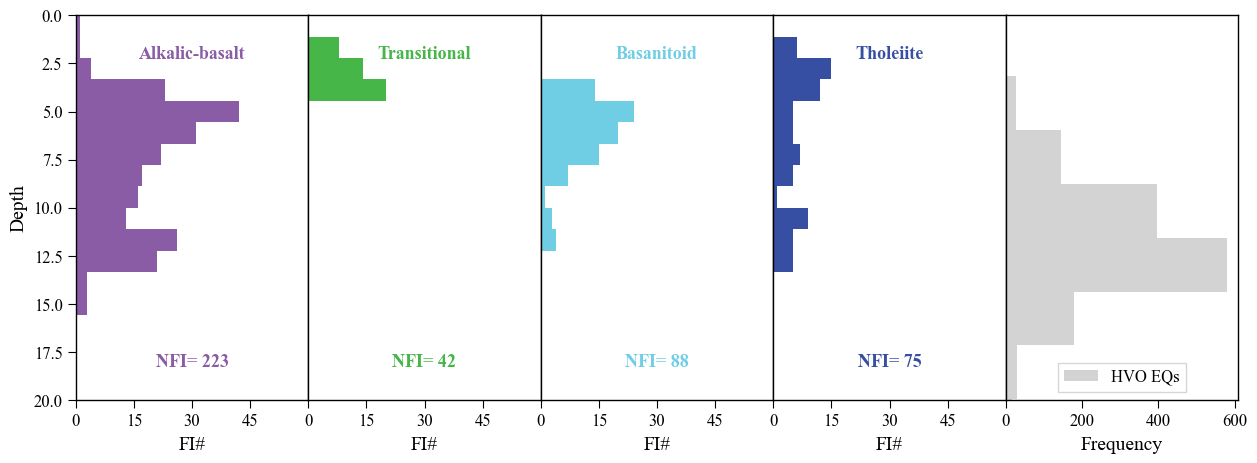

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming 'filtered_data' and 'eqs' are defined appropriately
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

bins = np.linspace(0, 20, 19)

# Plotting histograms
# ax1.hist(filtered_data['SingleCalc_D_km'][alkbas], ec='k', histtype='step', bins=15, alpha=0.3, label='2 step model', orientation='horizontal')
ax1.hist(filtered_data['Depth_km_4step'][alkbas], ec='none', fc='#8A5CA6', bins=bins, alpha=1, label='187-1 alkbas \n(2000mbsl)', orientation='horizontal')
# ax1.legend(loc='lower center')

# sns.violinplot(data=filtered_data['Depth_km_4step'][alkbas], inner='stick',ax=ax5)


ax1.set_xlabel('FI#')
ax1.set_ylabel('Depth')  # Set y-axis label only on the first subplot
ax1.tick_params(left=True, labelleft=True)  # Ensure ticks and labels are shown on the left axis
ax1.set_ylim([20, 0])  # Set y-axis limits

# ax2.hist(filtered_data['SingleCalc_D_km'][trans], ec='k', histtype='step', bins=8, alpha=0.3, label='2step', orientation='horizontal')
ax2.hist(filtered_data[['Depth_km_4step']][trans], ec='none', fc='#46B649', bins=bins, alpha=1, label='186-9 transitional \n(1460 mbsl)', orientation='horizontal')
# ax2.legend(loc='lower center')
ax2.set_xlabel('FI#')
ax2.yaxis.set_tick_params(left=False, labelleft=False)  # Remove y-axis ticks and labels
ax2.set_ylim([20, 0])  # Set y-axis limits

# ax3.hist(filtered_data['SingleCalc_D_km'][alk], ec='k', histtype='step', bins=8, alpha=0.3, label='2step', orientation='horizontal')
ax3.hist(filtered_data['Depth_km_4step'][alk], ec='none', fc='#6FCDE4', bins=bins, alpha=1, label='186-11  basanitoid \n(1210 mbsl)', orientation='horizontal')
# ax3.legend(loc='lower center')
ax3.set_xlabel('FI#')
ax3.yaxis.set_tick_params(left=False, labelleft=False)  # Remove y-axis ticks and labels
ax3.set_ylim([20, 0])  # Set y-axis limits

# ax4.hist(filtered_data['SingleCalc_D_km'][thol], histtype='step', edgecolor='black', bins=10, alpha=0.3, label='2step', orientation='horizontal')
ax4.hist(filtered_data['Depth_km_4step'][thol], ec='none', fc='#374FA2', bins=bins, alpha=1, label='187-9 thol \n(1080 mbsl)', orientation='horizontal')
# ax4.legend(loc='lower center')
ax4.set_xlabel('FI#')
ax4.yaxis.set_tick_params(left=False, labelleft=False)  # Remove y-axis ticks and labels
ax4.set_ylim([20, 0])  # Set y-axis limits


for ax in (ax1, ax2, ax3, ax4):
    max_limit = 60  # Get the current max limit
    if max_limit == 0:
        continue  # Skip if max limit is 0 to avoid division by zero
    
    # Calculate tick spacing based on max limit
    tick_spacing = max_limit / 4
    
    # Generate ticks
    ticks = np.arange(0, max_limit, tick_spacing)
    
    # Exclude the last tick if it equals the max limit
    if ticks[-1] == max_limit:
        ticks = ticks[:-1]
    
    ax.set_xlim([0, max_limit])  # Set the x-axis limits
    ax.set_xticks(ticks)  # Set the ticks for the x-axis


ax5.hist(eqs['depth'], ec='none', fc='lightgrey', bins=20, label='HVO EQs', orientation='horizontal')
ax5.set_xlabel('Frequency')
ax5.legend(loc='lower center')
ax5.yaxis.set_tick_params(left=False, labelleft=False)  # Remove y-axis ticks and labels
ax5.set_ylim([20, 0])  # Set y-axis limits
ax1.annotate(
    "Alkalic-basalt",
    xy=(0.5, 0.9),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#8A5CA6',
    fontweight='bold'
)
ax2.annotate(
    "Transitional",
    xy=(0.5, 0.9),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#46B649',
    fontweight='bold'
)
ax3.annotate(
    "Basanitoid",
    xy=(0.5, 0.9),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#6FCDE4',
    fontweight='bold'
)
ax4.annotate(
    "Tholeiite",
    xy=(0.5, 0.9),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#374FA2',
    fontweight='bold'
)

ax1.annotate(
    f'NFI= {len(filtered_data[alkbas])}',
    xy=(0.5, 0.1),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#8A5CA6',
    fontweight='bold'
)
ax2.annotate(
    f'NFI= {len(filtered_data[trans])}',
    xy=(0.5, 0.1),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#46B649',
    fontweight='bold'
)

ax3.annotate(
    f'NFI= {len(filtered_data[alk])}',
    xy=(0.5, 0.1),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#6FCDE4',
    fontweight='bold'
)
ax4.annotate(f'NFI= {len(filtered_data[thol])}',
    xy=(0.5, 0.1),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#374FA2',
    fontweight='bold'
)
plt.subplots_adjust(wspace=0)  # Adjust horizontal space between subplots

# plt.tight_layout()
fig.savefig(figpath+slash+'editable_figure.pdf', format='pdf', dpi=300, transparent=True)


## import loa and kil

In [32]:
loa=pd.read_excel(r"ML_for_Charlotte.xlsx")
kil=pd.read_excel(r"KIL.xlsx")
loa['D(km)_HC']
kil['Depth (km)']

0      1.193235
1      1.409866
2      1.596183
3      1.819663
4      2.041608
         ...   
310    1.288929
311    1.431997
312    1.554120
313    1.496305
314    2.046003
Name: Depth (km), Length: 315, dtype: float64

## import hualalai

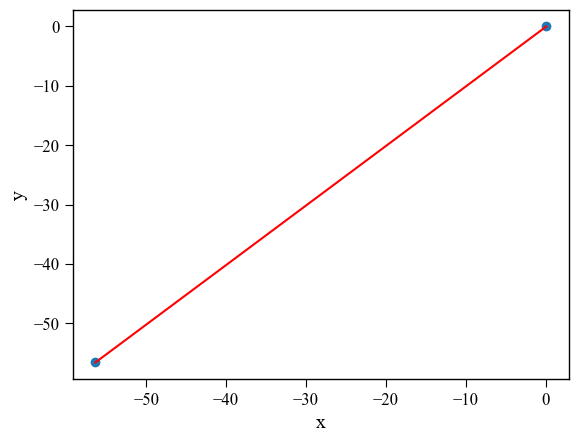

,Bulk_gcm3low,Liq_gcm3low,Gas_gcm3low,T_h_Clow,homog_tolow,Sample_ID,Bulk_gcm3high,Liq_gcm3high,Gas_gcm3high,T_h_Chigh,homog_tohigh,Mean_Bulk_gcm3,Std_Bulk_gcm3
0,0.644372,0.644372,0.298631,28.450265,L,-56.65,0.641790,0.641790,0.300910,28.550442,L,0.643081,0.001825
1,0.644372,0.644372,0.298631,28.450265,L,-56.65,0.639143,0.639143,0.303254,28.650619,L,0.641757,0.003697
2,0.644372,0.644372,0.298631,28.450265,L,-56.65,0.644372,0.644372,0.298631,28.450265,L,0.644372,0.000000
3,0.649354,0.649354,0.294251,28.249912,L,-57.65,0.646892,0.646892,0.296412,28.350088,L,0.648123,0.001741
4,0.641790,0.641790,0.300910,28.550442,L,-56.65,0.641790,0.641790,0.300910,28.550442,L,0.641790,0.000000
5,0.641790,0.641790,0.300910,28.550442,L,-56.65,0.639143,0.639143,0.303254,28.650619,L,0.640467,0.001872
6,0.641790,0.641790,0.300910,28.550442,L,-56.65,0.644372,0.644372,0.298631,28.450265,L,0.643081,0.001825
7,0.646892,0.646892,0.296412,28.350088,L,-56.65,0.641790,0.641790,0.300910,28.550442,L,0.644341,0.003607
8,0.646892,0.646892,0.296412,28.350088,L,-56.65,0.639143,0.639143,0.303254,28.650619,L,0.643017,0.005479
9,0.646892,0.646892,0.296412,28.350088,L,-56.65,0.644372,0.644372,0.298631,28.450265,L,0.645632,0.001782


You have entered a value for XH2O, so we are now using the EOS of Duan and Zhang 200 regardless of what model you selected. If you dont want this, specify XH2O=None
Please note, the DZ2006 EOS is about 5-40X slower to run than the SP94 and SW94 EOS
We are using multiprocessing based on your selected EOS. You can override this by setting multiprocess=False in the function, but it might slow it down a lot
Number of processors:  8


,Filename,i,CO2_density_input,SingleCalc_D_km,SingleCalc_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,...,T_K_input,error_T_K,CO2_dens_gcm3_input,error_CO2_dens_gcm3,crust_dens_kgm3_input,error_crust_dens_kgm3,model,EOS,XH2O_input,error_XH2O
0,Hualalai_81863_c1_FI2,0.0,0.643081,13.287894,3.615584,3.669927,3.631839,0.403222,0.377657,13.466948,...,1373.15,100.0,0.643081,0.001825,None,5.0,three-step,DZ06,0.1,0.05
1,Hualalai_81863_c1_FI3,1.0,0.641757,13.236877,3.601570,3.656407,3.621238,0.403150,0.379077,13.418671,...,1373.15,100.0,0.641757,0.003697,None,5.0,three-step,DZ06,0.1,0.05
2,Hualalai_81863_c1_FI4,2.0,0.644372,13.337797,3.629291,3.683229,3.644254,0.404254,0.380657,13.514318,...,1373.15,100.0,0.644372,0.000000,None,5.0,three-step,DZ06,0.1,0.05
3,Hualalai_81863_c1_FI5,3.0,0.648123,13.483668,3.669359,3.724829,3.686494,0.409850,0.383500,13.661970,...,1373.15,100.0,0.648123,0.001741,None,5.0,three-step,DZ06,0.1,0.05
4,Hualalai_81863_c1_FI6,4.0,0.641790,13.238138,3.601917,3.655270,3.616915,0.400867,0.377556,13.414853,...,1373.15,100.0,0.641790,0.000000,None,5.0,three-step,DZ06,0.1,0.05


In [33]:
hualalai=pd.read_excel("hualalai.xlsx")
from scipy.stats import linregress
import pickle
# Your data points
x = np.array([-56.4,0.1])
y = np.array([-56.6,0.0])

# Fit a linear regression model to your data
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Store the model coefficients in a dictionary
model = {'slope': slope, 'intercept': intercept}

# Store the model in a pickle file
with open('linkam_cali_reg.pkl', 'wb') as f:
    pickle.dump(model, f)



# Plot the data along with the regression line
plt.scatter(x, y)
plt.plot(x, slope*x + intercept, color='red')
plt.xlabel('x')
plt.ylabel('y')

plt.show()


# Load the model from the pickle file
with open('linkam_cali_reg.pkl', 'rb') as f:
    model = pickle.load(f)

# Predict new values
def correct_Th(*,model,Th):
    Th_array = np.array(Th)
    T_cal = model['slope'] * Th_array + model['intercept']
    return T_cal

# Load the model from the pickle file
with open('linkam_cali_reg.pkl', 'rb') as f:
    model = pickle.load(f)

# Predict new values
def correct_Th(*,model,Th):
    Th_array = np.array(Th)
    T_cal = model['slope'] * Th_array + model['intercept']
    return T_cal

Tlow=hualalai['Th_low']
Thigh=hualalai['Th_high']
Tmelt=hualalai['Tmelt']
sample_ID=hualalai['Tmelt']
Ts=[Tlow,Thigh]

Tcorr_dict={}
for T in Ts:
    name=T.name
    T_corr=correct_Th(model=model,Th=T)
    Tcorr_dict[name]=T_corr

rho_dict={}
for T in Tcorr_dict:
    if 'melt' not in T:
        rho=pf.calculate_CO2_density_homog_T(T_h_C=Tcorr_dict[T], Sample_ID=sample_ID,
                                    homog_to='L', EOS='SW96')
        rho_dict[T]=rho

rho_merge=pd.merge(rho_dict['Th_low'],rho_dict['Th_high'],on='Sample_ID',suffixes=['low','high'])

rho_merge['Mean_Bulk_gcm3']=rho_merge[['Bulk_gcm3low', 'Bulk_gcm3high']].mean(axis=1)
rho_merge['Std_Bulk_gcm3']=rho_merge[['Bulk_gcm3low', 'Bulk_gcm3high']].std(axis=1)

display(rho_merge)
hualalai['CO2_density_gcm3']=rho_merge['Mean_Bulk_gcm3']
hualalai['CO2_density_gcm3_st']=rho_merge['Std_Bulk_gcm3']


## Duan and Zhang Error propagate. 
MC_Av_hualalai, MC_All_hualalai, fig=pf.propagate_FI_uncertainty(
T_K=1100+273.15,error_T_K=100, error_type_T_K='Abs', error_dist_T_K='normal',
CO2_dens_gcm3=hualalai['CO2_density_gcm3'],error_CO2_dens=hualalai['CO2_density_gcm3_st'], error_type_CO2_dens='Abs', error_dist_CO2_dens='normal',
XH2O=0.1, error_XH2O=0.05, error_type_XH2O='Abs', error_dist_XH2O='normal',
sample_ID=hualalai['Sample_ID'],
model='three-step',d1=7,rho1=2750,d2=15,rho2=2800, rho3=3200,error_crust_dens=5, error_type_crust_dens='Perc', error_dist_crust_dens='normal', 
N_dup=500, fig_i=0, plot_figure=False)

MC_Av_hualalai.head()



In [34]:
hualalai['P (kbar)']=MC_Av_hualalai['SingleCalc_P_kbar']
hualalai['Depth (km)']=MC_Av_hualalai['SingleCalc_D_km']
hualalai

,Tmelt,Th_low,Th_high,Sample_ID,CO2_density_gcm3,CO2_density_gcm3_st,P (kbar),Depth (km)
0,-56.65,28.5,28.6,Hualalai_81863_c1_FI2,0.643081,0.001825,3.615584,13.287894
1,-57.65,28.3,28.4,Hualalai_81863_c1_FI3,0.641757,0.003697,3.601570,13.236877
2,-56.65,28.6,28.7,Hualalai_81863_c1_FI4,0.644372,0.000000,3.629291,13.337797
3,-56.65,28.4,28.5,Hualalai_81863_c1_FI5,0.648123,0.001741,3.669359,13.483668
4,-56.55,28.1,28.2,Hualalai_81863_c1_FI6,0.641790,0.000000,3.601917,13.238138
5,-56.85,28.2,28.3,Hualalai_81863_c2_FI1,0.640467,0.001872,3.587944,13.187269
6,-56.75,27.9,28.0,Hualalai_81863_c2_FI3,0.643081,0.001825,3.615584,13.287894
7,NaN,27.4,27.5,Hualalai_81863_c2_FI4,0.644341,0.003607,3.628965,13.336609
8,-56.35,29.0,29.1,Hualalai_81863_c3_FI1,0.643017,0.005479,3.614911,13.285446
9,-56.25,28.7,28.8,Hualalai_81863_c3_FI2,0.645632,0.001782,3.642711,13.386655


## Plot all

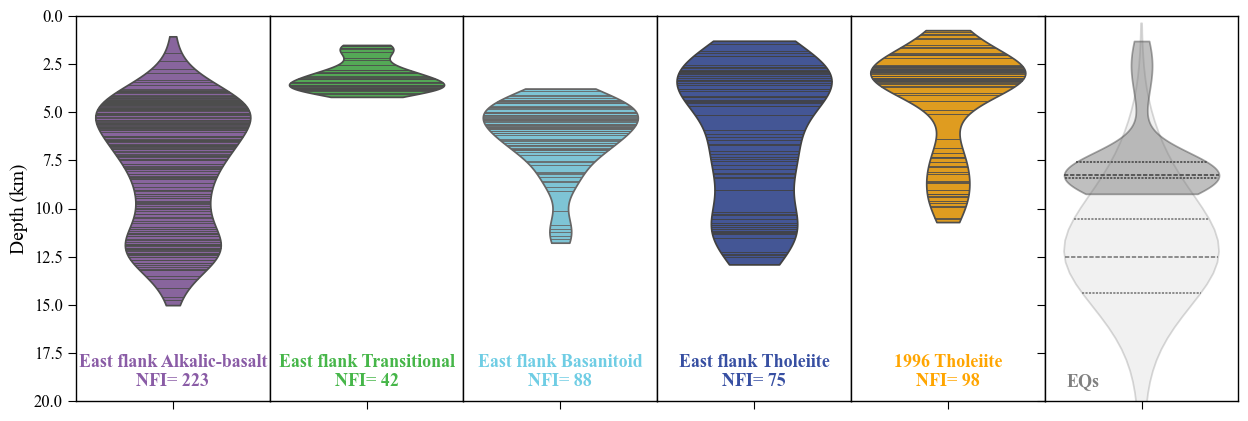

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming 'filtered_data' and 'eqs' are defined appropriately
fig, (ax1, ax2, ax3, ax4, ax5,ax6) = plt.subplots(1, 6, figsize=(15, 5), sharey=True)

bins = np.linspace(0, 20, 19)

sns.violinplot(data=filtered_data['Depth_km_4step'][alkbas], color='#8A5CA6',inner='stick',ax=ax1,cut=0)
sns.violinplot(data=filtered_data['Depth_km_4step'][trans], color='#46B649',inner='stick',ax=ax2,cut=0)
sns.violinplot(data=filtered_data['Depth_km_4step'][alk], color='#6FCDE4',inner='stick',ax=ax3,cut=0)
sns.violinplot(data=filtered_data['Depth_km_4step'][thol], color='#374FA2',inner='stick',ax=ax4,cut=0)
sns.violinplot(filtered_data['Depth_km_4step'][thol_96], color='orange',inner='stick',ax=ax5,cut=0)
sns.violinplot(data=eqs['depth'], color='lightgrey',inner='quart',alpha=0.3,ax=ax6,cut=0)
sns.violinplot(data=quakes_obs['Depth (km)'], color='grey',inner='quart',alpha=0.5,ax=ax6,cut=0)

ax1.set_ylabel('Depth (km)')  # Set y-axis label only on the first subplot
ax1.tick_params(left=True, labelleft=True)  # Ensure ticks and labels are shown on the left axis

for ax in (ax1, ax2, ax3, ax4, ax5):
    ax.set_ylim([20, 0])  # Set y-axis limits
    if ax in (ax2,ax3,ax4,ax5):      
        ax.yaxis.set_tick_params(left=False, labelleft=False)  # Remove y-axis ticks and labels


ax1.annotate(
    "East flank Alkalic-basalt",
    xy=(0.5, 0.1),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#8A5CA6',
    fontweight='bold'
)
ax2.annotate(
    "East flank Transitional",
    xy=(0.5, 0.1),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#46B649',
    fontweight='bold'
)
ax3.annotate(
    "East flank Basanitoid",
    xy=(0.5, 0.1),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#6FCDE4',
    fontweight='bold'
)
ax4.annotate(
    "East flank Tholeiite",
    xy=(0.5, 0.1),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#374FA2',
    fontweight='bold'
)
ax5.annotate(
    "1996 Tholeiite",
    xy=(0.5, 0.1),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='orange',
    fontweight='bold'
)

ax1.annotate(
    f'NFI= {len(filtered_data[alkbas])}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#8A5CA6',
    fontweight='bold'
)
ax2.annotate(
    f'NFI= {len(filtered_data[trans])}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#46B649',
    fontweight='bold'
)

ax3.annotate(
    f'NFI= {len(filtered_data[alk])}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#6FCDE4',
    fontweight='bold'
)
ax4.annotate(f'NFI= {len(filtered_data[thol])}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='#374FA2',
    fontweight='bold'
)
ax5.annotate(f'NFI= {len(filtered_data[thol_96])}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='orange',
    fontweight='bold'
)
ax6.annotate(f'EQs',
    xy=(0.2, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color='Grey',
    fontweight='bold'
)
plt.subplots_adjust(wspace=0)  # Adjust horizontal space between subplots

# plt.tight_layout()
fig.savefig(figpath+slash+'editable_figure.pdf', format='pdf', dpi=300, transparent=True)


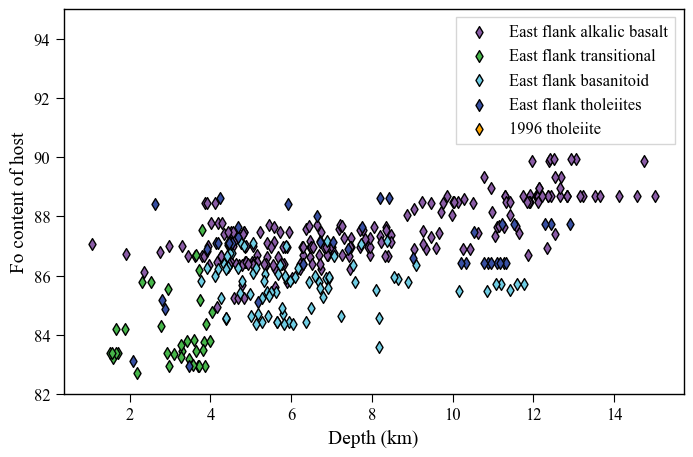

In [80]:
fig, (ax1) = plt.subplots(1, 1, figsize = (8,5))


ax1.scatter( filtered_data['Depth_km_4step'][alkbas], filtered_data['Fo_host'][alkbas]*100,
             marker='d',   facecolor='#8A5CA6', edgecolor='k', label='East flank alkalic basalt',zorder=1)
ax1.scatter( filtered_data['Depth_km_4step'][trans], filtered_data['Fo_host'][trans]*100,
             marker='d',   facecolor='#46B649', edgecolor='k', label='East flank transitional',zorder=1)
ax1.scatter( filtered_data['Depth_km_4step'][alk], filtered_data['Fo_host'][alk]*100,
             marker='d',   facecolor='#6FCDE4', edgecolor='k', label='East flank basanitoid',zorder=1)
ax1.scatter( filtered_data['Depth_km_4step'][thol], filtered_data['Fo_host'][thol]*100,
             marker='d',   facecolor='#374FA2', edgecolor='k', label='East flank tholeiites',zorder=1)
ax1.scatter( filtered_data['Depth_km_4step'][thol_96], filtered_data['Fo_host'][thol_96]*100,
             marker='d',   facecolor='orange', edgecolor='k', label='1996 tholeiite',zorder=1)

ax1.set_ylabel('Fo content of host')
ax1.set_xlabel('Depth (km)')
ax1.set_ylim([82,95])
plt.legend()#

# plt.tight_layout()
fig.savefig(figpath+slash+'FovsDepth.pdf', format='pdf', dpi=300, transparent=True)

In [ ]:
histogram( filtered_data['Fo_host'][alkbas],
             marker='d',   facecolor='#8A5CA6', edgecolor='k', label='East flank alkalic basalt',zorder=1)

AttributeError: module 'matplotlib.pyplot' has no attribute 'histogram'

## This uses the raw glass data for some quick plots


In [104]:
all_glasses=pd.read_excel("KAM_EDS_12062024.xlsx",sheet_name="concatenated_glasses")
all_glasses=all_glasses[~(all_glasses['MgO']>20)&~(all_glasses['Sample Name'].str.contains("AMG"))]

alkbas_gl = all_glasses['Sample Name'].str.contains('187-1|L1|L87|KA71')
trans_gl = all_glasses['Sample Name'].str.contains('186-9|L69|KA69')
alk_gl = all_glasses['Sample Name'].str.contains('186-11|L11|KA611')
thol_gl = all_glasses['Sample Name'].str.contains('187-9|L79|KA79|187-8|KA78')
thol_96_gl=all_glasses['Sample Name'].str.contains('187-9|L79|KA79|187-8|KA78')

mat_glasses=all_glasses[all_glasses['Sample Name'].str.contains("mat")]
MI_glasses=all_glasses[~all_glasses['Sample Name'].str.contains("mat")]

Text(0, 0.5, 'FeOt')

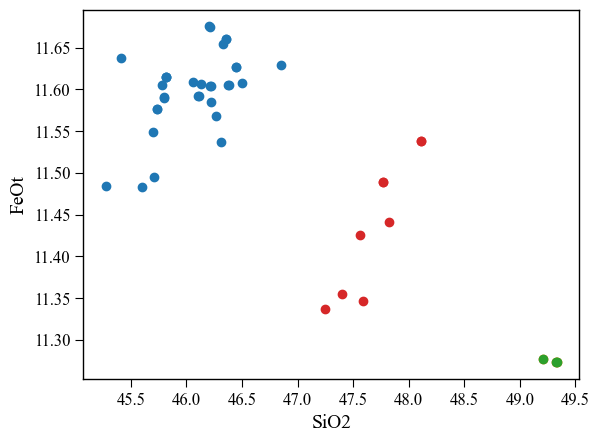

In [93]:
alkbas_matgl = mat_glasses['Sample Name'].str.contains('187-1|L1|L87|KA71')
trans_matgl = mat_glasses['Sample Name'].str.contains('186-9|L69|KA69')
alk_matgl = mat_glasses['Sample Name'].str.contains('186-11|L11|KA611')
thol_matgl = mat_glasses['Sample Name'].str.contains('187-9|L79|KA79|187-8|KA78')
thol_96_matgl=mat_glasses['Sample Name'].str.contains('187-9|L79|KA79|187-8|KA78')

plt.scatter(mat_glasses['SiO2'][alkbas_gl],mat_glasses['FeOt'][alkbas_gl])
plt.scatter(mat_glasses['SiO2'][thol_gl],mat_glasses['FeOt'][thol_gl])
plt.scatter(mat_glasses['SiO2'][thol_96_gl],mat_glasses['FeOt'][thol_96_gl])
plt.scatter(mat_glasses['SiO2'][trans_gl],mat_glasses['FeOt'][trans_gl])
plt.scatter(mat_glasses['SiO2'][alk_gl],mat_glasses['FeOt'][alk_gl])
plt.xlabel("SiO2")
plt.ylabel("FeOt")

Text(0, 0.5, 'FeOt')

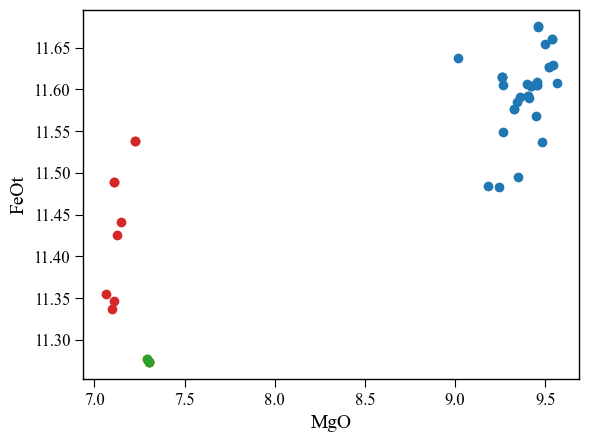

In [95]:
plt.scatter(mat_glasses['MgO'][alkbas_gl],mat_glasses['FeOt'][alkbas_gl])
plt.scatter(mat_glasses['MgO'][thol_gl],mat_glasses['FeOt'][thol_gl])
plt.scatter(mat_glasses['MgO'][thol_96_gl],mat_glasses['FeOt'][thol_96_gl])
plt.scatter(mat_glasses['MgO'][trans_gl],mat_glasses['FeOt'][trans_gl])
plt.scatter(mat_glasses['MgO'][alk_gl],mat_glasses['FeOt'][alk_gl])
plt.xlabel("MgO")
plt.ylabel("FeOt")

Text(0, 0.5, 'FeOt')

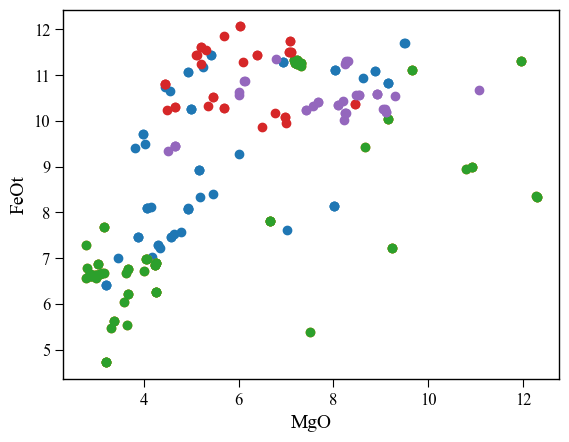

In [ ]:
plt.scatter(mat_glasses['MgO'][alkbas_gl],mat_glasses['FeOt'][alkbas_gl])
plt.scatter(mat_glasses['MgO'][thol_gl],mat_glasses['FeOt'][thol_gl])
plt.scatter(mat_glasses['MgO'][thol_96_gl],mat_glasses['FeOt'][thol_96_gl])
plt.scatter(mat_glasses['MgO'][trans_gl],mat_glasses['FeOt'][trans_gl])
plt.scatter(mat_glasses['MgO'][alk_gl],mat_glasses['FeOt'][alk_gl])
plt.xlabel("MgO")
plt.ylabel("FeOt")


Text(0, 0.5, 'FeOt')

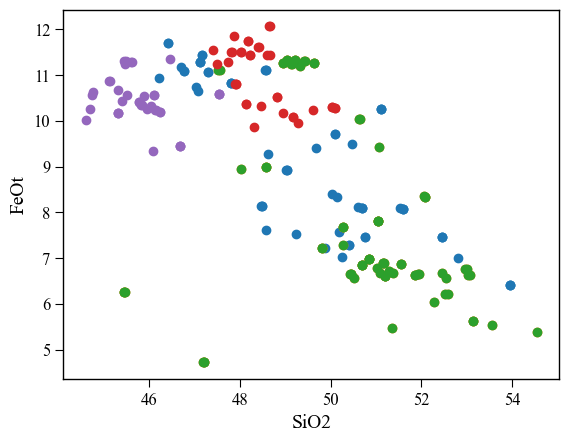

In [94]:
alkbas_MIgl = MI_glasses['Sample Name'].str.contains('187-1|L1|L87|KA71')
trans_MIgl = MI_glasses['Sample Name'].str.contains('186-9|L69|KA69')
alk_MIgl = MI_glasses['Sample Name'].str.contains('186-11|L11|KA611')
thol_MIgl = MI_glasses['Sample Name'].str.contains('187-9|L79|KA79|187-8|KA78')
thol_96_MIgl=MI_glasses['Sample Name'].str.contains('187-9|L79|KA79|187-8|KA78')

plt.scatter(MI_glasses['SiO2'][alkbas_gl],MI_glasses['FeOt'][alkbas_gl])
plt.scatter(MI_glasses['SiO2'][thol_gl],MI_glasses['FeOt'][thol_gl])
plt.scatter(MI_glasses['SiO2'][thol_96_gl],MI_glasses['FeOt'][thol_96_gl])
plt.scatter(MI_glasses['SiO2'][trans_gl],MI_glasses['FeOt'][trans_gl])
plt.scatter(MI_glasses['SiO2'][alk_gl],MI_glasses['FeOt'][alk_gl])
plt.xlabel("SiO2")
plt.ylabel("FeOt")

Text(0, 0.5, 'FeOt')

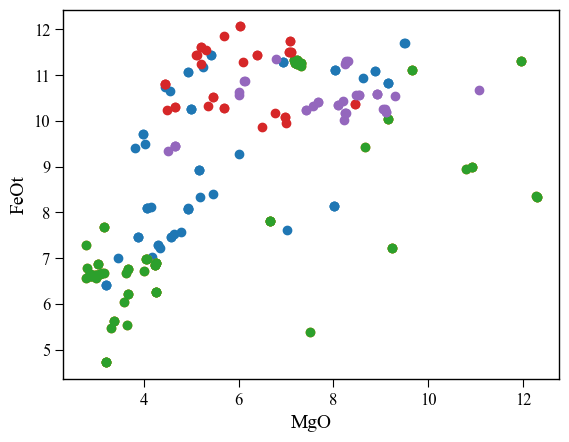

In [96]:
plt.scatter(MI_glasses['MgO'][alkbas_gl],MI_glasses['FeOt'][alkbas_gl])
plt.scatter(MI_glasses['MgO'][thol_gl],MI_glasses['FeOt'][thol_gl])
plt.scatter(MI_glasses['MgO'][thol_96_gl],MI_glasses['FeOt'][thol_96_gl])
plt.scatter(MI_glasses['MgO'][trans_gl],MI_glasses['FeOt'][trans_gl])
plt.scatter(MI_glasses['MgO'][alk_gl],MI_glasses['FeOt'][alk_gl])
plt.xlabel("MgO")
plt.ylabel("FeOt")

## import flux curve

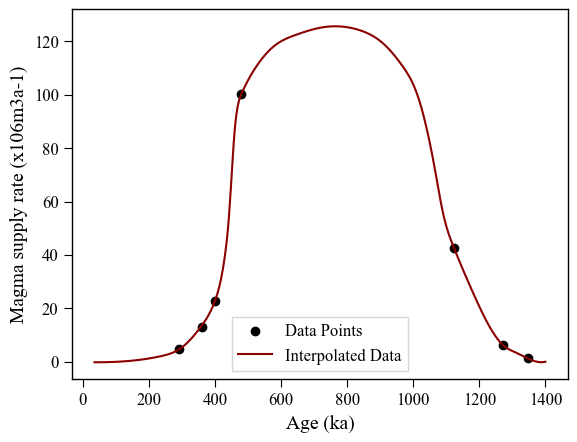

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pickle

# Load the data
flux = pd.read_csv("fluxhawaii.csv", header=None)
flux = flux.rename(columns={0: "Age (ka)", 1: "Magma supply rate (x106m3a-1)"})
flux = flux.sort_values(by="Age (ka)")

flux_spots = pd.read_csv("fluxhawaii_spots.csv", header=None)
flux_spots = flux_spots.rename(columns={0: "Age (ka)", 1: "Magma supply rate (x106m3a-1)"})
flux_spots = flux_spots.sort_values(by="Age (ka)")

# Interpolating the data
age = flux["Age (ka)"].values
supply_rate = flux["Magma supply rate (x106m3a-1)"].values

# Choose interpolation method: 'linear', 'quadratic', 'cubic', etc.
interpolator = interp1d(age, supply_rate, kind='cubic', fill_value="extrapolate")

# Create a new set of age values for interpolation
new_age = np.linspace(age.min(), age.max(), num=500)  # Adjust 'num' for resolution
new_supply_rate = interpolator(new_age)

# Save the interpolated data
interpolated_data = pd.DataFrame({
    "Age (ka)": new_age,
    "Magma supply rate (x106m3a-1)": new_supply_rate
})

# Save as pickle
with open("interpolated_flux.pkl", "wb") as f:
    pickle.dump(interpolated_data, f)

# Optional: Plotting the original and interpolated data
plt.scatter(flux_spots["Age (ka)"], flux_spots["Magma supply rate (x106m3a-1)"], marker='o', color='k', label='Data Points')
plt.plot(new_age, new_supply_rate, label='Interpolated Data', linestyle='-', color='darkred')
plt.xlabel('Age (ka)')
plt.ylabel('Magma supply rate (x106m3a-1)')
plt.legend()

plt.savefig(figpath+slash+"magma_supply_rate_plot.pdf", format='pdf', dpi=300, transparent=True)
plt.show()



## Plot with all KAM, KIL, and ML

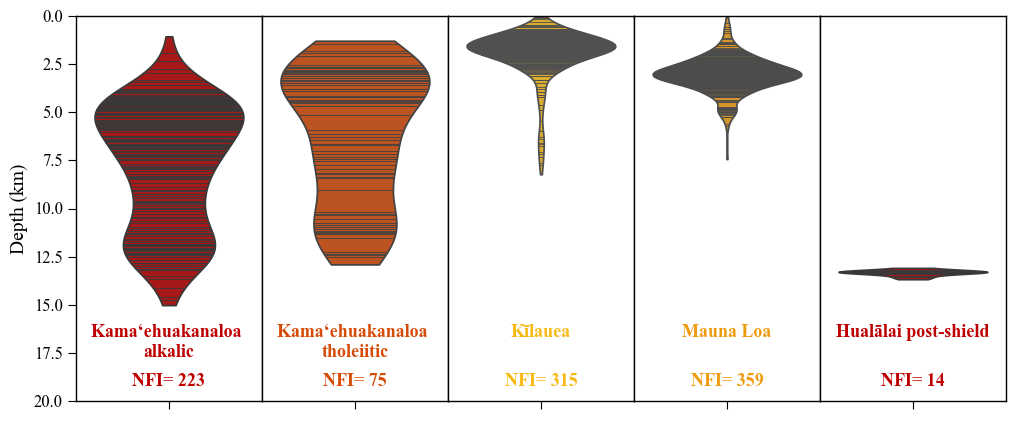

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming 'filtered_data' and 'eqs' are defined appropriately
fig, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(1, 5, figsize=(12, 5), sharey=True)

bins = np.linspace(0, 20, 19)

ax1_color='#BF0000'
ax2_color='#D64B07'
ax3_color='#F7B912'
ax4_color='#EE9B0F'
ax5_color='#BF0000'

sns.violinplot(data=filtered_data['Depth_km_4step'][alkbas], color=ax1_color,inner='stick',ax=ax1,cut=0)
sns.violinplot(data=filtered_data['Depth_km_4step'][thol], color=ax2_color,inner='stick',ax=ax2,cut=0)
sns.violinplot(data=kil['Depth (km)'], color=ax3_color,inner='stick',ax=ax3,cut=0)
sns.violinplot(data=loa['D(km)_HC'], color=ax4_color,inner='stick',ax=ax4,cut=0)
sns.violinplot(data=hualalai['Depth (km)'], color=ax5_color,inner='stick',ax=ax5,cut=0)


ax1.set_ylabel('Depth (km)')  # Set y-axis label only on the first subplot
ax1.tick_params(left=True, labelleft=True)  # Ensure ticks and labels are shown on the left axis

for ax in (ax1, ax2, ax3, ax4, ax5):
    ax.set_ylim([20, 0])  # Set y-axis limits
    if ax in (ax2,ax3,ax4,ax5):      
        ax.yaxis.set_tick_params(left=False, labelleft=False)  # Remove y-axis ticks and labels


ax1.annotate(
    "Kamaʻehuakanaloa \nalkalic",
    xy=(0.5, 0.20),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='top',
    color=ax1_color,
    fontweight='bold'
)

ax2.annotate(
    "Kamaʻehuakanaloa \ntholeiitic",
    xy=(0.5, 0.20),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='top',
    color=ax2_color,
    fontweight='bold'
)

ax3.annotate(
    "Kīlauea",
    xy=(0.5, 0.20),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='top',
    color=ax3_color,
    fontweight='bold'
)

ax4.annotate(
    "Mauna Loa",
    xy=(0.5, 0.20),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='top',
    color=ax4_color,
    fontweight='bold'
)

ax5.annotate(
    "Hualālai post-shield",
    xy=(0.5, 0.20),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='top',
    color=ax5_color,
    fontweight='bold'
)

ax1.annotate(
    f'NFI= {len(filtered_data[alkbas])}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color=ax1_color,
    fontweight='bold'
)
ax2.annotate(
    f'NFI= {len(filtered_data[thol])}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color=ax2_color,
    fontweight='bold'
)

ax3.annotate(
    f'NFI= {len(kil)}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color=ax3_color,
    fontweight='bold'
)

ax4.annotate(
    f'NFI= {len(loa)}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color=ax4_color,
    fontweight='bold'
)

ax5.annotate(
    f'NFI= {len(hualalai)}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color=ax5_color,
    fontweight='bold'
)

plt.subplots_adjust(wspace=0)  # Adjust horizontal space between subplots

# plt.tight_layout()
fig.savefig(figpath+slash+'ALLKAM_ML_KIL_sep.pdf', format='pdf', dpi=300, transparent=True)


## ALL KAM KIL ML only

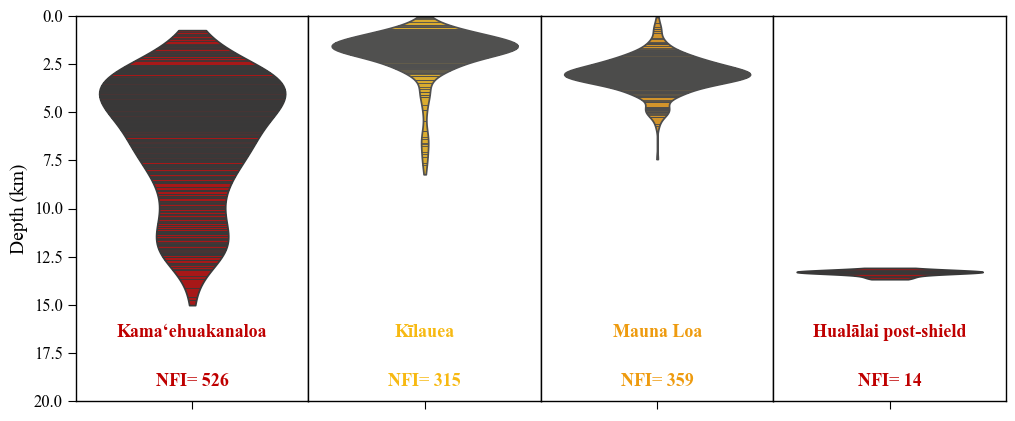

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming 'filtered_data' and 'eqs' are defined appropriately
fig, (ax1, ax3, ax4,ax5) = plt.subplots(1, 4, figsize=(12, 5), sharey=True)

bins = np.linspace(0, 20, 19)

ax1_color='#BF0000'
# ax2_color='#D64B07'
ax3_color='#F7B912'
ax4_color='#EE9B0F'
ax5_color='#BF0000'

sns.violinplot(data=filtered_data['Depth_km_4step'], color=ax1_color,inner='stick',ax=ax1,cut=0)
sns.violinplot(data=kil['Depth (km)'], color=ax3_color,inner='stick',ax=ax3,cut=0)
sns.violinplot(data=loa['D(km)_HC'], color=ax4_color,inner='stick',ax=ax4,cut=0)
sns.violinplot(data=hualalai['Depth (km)'], color=ax5_color,inner='stick',ax=ax5,cut=0)


ax1.set_ylabel('Depth (km)')  # Set y-axis label only on the first subplot
ax1.tick_params(left=True, labelleft=True)  # Ensure ticks and labels are shown on the left axis

for ax in (ax1, ax2, ax3, ax4, ax5):
    ax.set_ylim([20, 0])  # Set y-axis limits
    if ax in (ax2,ax3,ax4,ax5):      
        ax.yaxis.set_tick_params(left=False, labelleft=False)  # Remove y-axis ticks and labels


ax1.annotate(
    "Kamaʻehuakanaloa",
    xy=(0.5, 0.20),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='top',
    color=ax1_color,
    fontweight='bold'
)

ax3.annotate(
    "Kīlauea",
    xy=(0.5, 0.20),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='top',
    color=ax3_color,
    fontweight='bold'
)

ax4.annotate(
    "Mauna Loa",
    xy=(0.5, 0.20),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='top',
    color=ax4_color,
    fontweight='bold'
)
ax5.annotate(
    "Hualālai post-shield",
    xy=(0.5, 0.20),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='top',
    color=ax5_color,
    fontweight='bold'
)

ax1.annotate(
    f'NFI= {len(filtered_data)}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color=ax1_color,
    fontweight='bold'
)

ax3.annotate(
    f'NFI= {len(kil)}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color=ax3_color,
    fontweight='bold'
)

ax4.annotate(
    f'NFI= {len(loa)}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color=ax4_color,
    fontweight='bold'
)
ax5.annotate(
    f'NFI= {len(hualalai)}',
    xy=(0.5, 0.05),  # Coordinates as fractions of the axes
    xycoords='axes fraction',  # Use 'axes fraction' for relative positioning
    fontsize=13,
    ha='center',
    va='center',
    color=ax5_color,
    fontweight='bold'
)
plt.subplots_adjust(wspace=0)  # Adjust horizontal space between subplots

# plt.tight_layout()
fig.savefig(figpath+slash+'ALLKAM_ML_KIL.pdf', format='pdf', dpi=300, transparent=True)


## Average by crystal 

In [ ]:
kam_FI_4xtal_average=kam_FI.copy()

grouped = kam_FI_4xtal_average.groupby('Sample_crystal')

# Separate numeric and non-numeric columns
numeric_cols =kam_FI_4xtal_average.select_dtypes(include='number')
non_numeric_cols = kam_FI_4xtal_average.select_dtypes(exclude='number')

# Aggregate numeric columns by mean and standard deviation
numeric_kamaehu_xtal_averaged_mean = grouped[numeric_cols.columns].mean()
numeric_kamaehu_xtal_averaged_std = grouped[numeric_cols.columns].std()

# Take the first instance for non-numeric columns
non_numeric_kamaehu_xtal_averaged = grouped[non_numeric_cols.columns].first()

# Concatenate kamaehu_xtal_averageds and reindex columns to the original order
kamaehu_xtal_averaged = pd.concat([numeric_kamaehu_xtal_averaged_mean, non_numeric_kamaehu_xtal_averaged], axis=1)
kamaehu_xtal_averaged = kamaehu_xtal_averaged.reindex(columns=kam_FI_4xtal_average.columns)

# Add standard deviation columns after reindexing
kamaehu_xtal_averaged = pd.concat([kamaehu_xtal_averaged, numeric_kamaehu_xtal_averaged_std.add_suffix('_std')], axis=1)

# Reset index to get a DataFrame
kamaehu_xtal_averaged = kamaehu_xtal_averaged.reset_index(drop=True)

row_counts = grouped.size().reset_index(name='row_count')

# Add a new column "averaged?" based on the row count
row_counts['averagedbyxtal?'] = 'No'
row_counts.loc[row_counts['row_count'] > 1, 'averagedbyxtal?'] = 'Yes'

# Merge the row counts back to the aggregated DataFrame
kamaehu_xtal_averaged = pd.merge(kamaehu_xtal_averaged, row_counts[['Sample_crystal', 'averagedbyxtal?']], on='Sample_crystal', how='left')

# If there are missing values (groups with a single row), fill them with 'No'
kamaehu_xtal_averaged['averagedbyxtal?'] = kamaehu_xtal_averaged['averagedbyxtal?'].fillna('No')

kamaehu_xtal_averaged.to_excel(compilation_folder+'/'+"KAM_xtal_averaged.xlsx")

kamaehu_xtal_averaged


,filename,date_object,Type,Mount,Sample,Crystal,Region,FI#,Sample_crystal,Sample_crystal_region,...,T_K_input_std,error_T_K_std,CO2_dens_gcm3_input_std,error_CO2_dens_gcm3_std,error_crust_dens_kgm3_std,XH2O_input_std,error_XH2O_std,P_MPa_minus10_std,Depth_km_4step_std,averagedbyxtal?
0,186-11-101-C-rep1,2024-06-25,Sample,KAM1,KA611,c101,a2,FIC,KA611_c101,KA611_c101_a2,...,70.361658,0.0,0.021802,0.014910,0.0,0.031945,0.0,7.358464,0.283056,Yes
1,186-11-102-C,2024-06-25,Sample,KAM1,KA611,c102,a1,FIC,KA611_c102,KA611_c102_a1,...,0.000000,0.0,0.052970,0.000144,0.0,0.000000,0.0,33.185692,1.248004,Yes
2,186-11-103-B,2024-06-25,Sample,KAM1,KA611,c103,a1,FIB,KA611_c103,KA611_c103_a1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3,186-11-104-A,2024-06-25,Sample,KAM1,KA611,c104,a1,FIA,KA611_c104,KA611_c104_a1,...,0.000000,0.0,0.025138,0.000917,0.0,0.000000,0.0,13.673498,0.525975,Yes
4,186-11-105-B,2024-06-25,Sample,KAM1,KA611,c105,a1,FIB,KA611_c105,KA611_c105_a1,...,0.000000,0.0,0.064070,0.001854,0.0,0.000000,0.0,41.945276,1.554563,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,KA961_c155_a1_FIA,2024-12-03,Sample,KAM6,KA961,c155,a1,FIA,KA961_c155,KA961_c155_a1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
181,KA961_c156_a1_FIA,2024-12-03,Sample,KAM6,KA961,c156,a1,FIA,KA961_c156,KA961_c156_a1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
182,KA961_c157_a1_FIA,2024-12-03,Sample,KAM6,KA961,c157,a1,FIA,KA961_c157,KA961_c157_a1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
183,KA961_c158_a2_FIB,2024-12-03,Sample,KAM6,KA961,c158,a2,FIB,KA961_c158,KA961_c158_a2,...,0.000000,0.0,0.063391,0.001328,0.0,0.040497,0.0,25.128435,0.966608,Yes


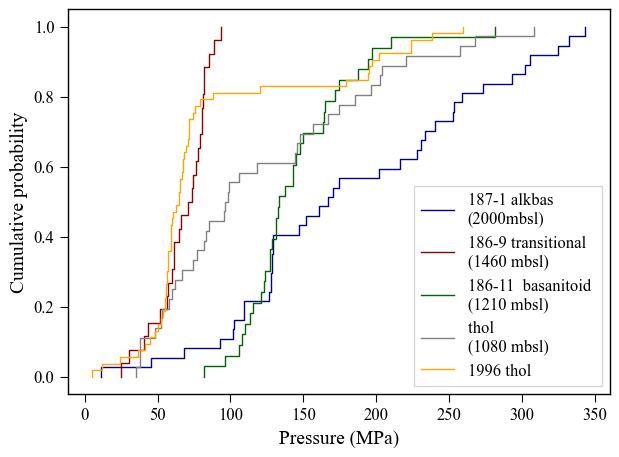

In [109]:
import matplotlib.pyplot as plt

kam_FI_4xtal_average = kamaehu_xtal_averaged.copy()

## Create sample filters
## Create sample filters
alkbas = kam_FI_4xtal_average['Sample'].str.contains('187-1|L87|L1|KA71')
trans = kam_FI_4xtal_average['Sample'].str.contains('186-9|L69|KA69')
alk = kam_FI_4xtal_average['Sample'].str.contains('186-11|L11|KA611')
# thol_1 = kam_FI_4xtal_average['Sample'].str.contains('187-8|KA78')
thol = kam_FI_4xtal_average['Sample'].str.contains('187-9|L79|KA79|187-8|KA78')
thol_96 = kam_FI_4xtal_average['Sample'].str.contains('KA961|KA962')

fig, (ax1) = plt.subplots(1, 1, figsize=(7,5))

x1=100*kam_FI_4xtal_average['SingleCalc_P_kbar'][alkbas]
x1_sorted=np.sort(x1)
ax1.step(np.concatenate([x1_sorted, x1_sorted[[-1]]]),
         np.arange(x1_sorted.size+1)/x1_sorted.size, color='darkblue', linewidth=1, label='187-1 alkbas \n(2000mbsl)')

x2=100*kam_FI_4xtal_average['SingleCalc_P_kbar'][trans]
x2_sorted=np.sort(x2)
ax1.step(np.concatenate([x2_sorted, x2_sorted[[-1]]]),
         np.arange(x2_sorted.size+1)/x2_sorted.size, color='darkred', linewidth=1, label='186-9 transitional \n(1460 mbsl)')

x3=100*kam_FI_4xtal_average['SingleCalc_P_kbar'][alk]
x3_sorted=np.sort(x3)
ax1.step(np.concatenate([x3_sorted, x3_sorted[[-1]]]),
         np.arange(x3_sorted.size+1)/x3_sorted.size, color='darkgreen', linewidth=1, label='186-11  basanitoid \n(1210 mbsl)')

# x4=100*kam_FI_4xtal_average['SingleCalc_P_kbar'][thol_1]
# x4_sorted=np.sort(x4)
# ax1.step(np.concatenate([x4_sorted, x4_sorted[[-1]]]),
#          np.arange(x4_sorted.size+1)/x4_sorted.size, color='orange', linewidth=1, label='187-8 thol \n(1130 mbsl)')

x5=100*kam_FI_4xtal_average['SingleCalc_P_kbar'][thol]
x5_sorted=np.sort(x5)
ax1.step(np.concatenate([x5_sorted, x5_sorted[[-1]]]),
         np.arange(x5_sorted.size+1)/x5_sorted.size, color='grey', linewidth=1, label='thol \n(1080 mbsl)')

x5=100*kam_FI_4xtal_average['SingleCalc_P_kbar'][thol_96]
x5_sorted=np.sort(x5)
ax1.step(np.concatenate([x5_sorted, x5_sorted[[-1]]]),
         np.arange(x5_sorted.size+1)/x5_sorted.size, color='orange', linewidth=1, label='1996 thol')


plt.legend()
ax1.set_xlabel("Pressure (MPa)")
ax1.set_ylabel("Cumulative probability")
# plt.tight_layout()
fig.savefig(figpath+slash+'cdf_samples.pdf', format='pdf', dpi=300, transparent=True)
